In [1]:
try: import datasets; print(f"datasets: {datasets.__version__}") 
except ImportError: print("datasets: Not installed.") 
try: import torch; print(f"torch: {torch.__version__}") 
except ImportError: print("torch: Not installed.") 
try: import numpy; print(f"numpy: {numpy.__version__}") 
except ImportError: print("numpy: Not installed.") 
try: import tqdm; print(f"tqdm: {tqdm.__version__}") 
except ImportError: print("tqdm: Not installed.") 

datasets: 3.5.0
torch: 2.4.1+cu124
numpy: 2.2.5
tqdm: 4.67.1


In [1]:
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import numpy as np
# import torch.nn.functional as F
from torch.utils.data import DataLoader
from preprocessing import add_representations, fen_to_piece_maps, fen_to_token_ids
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == torch.device("cpu"):
    print("Using CPU, not recommended")

In [3]:
def collate_fn(batch):
    batch_fens = [example['fen'] for example in batch]
    labels = torch.tensor(
        [example['target'] for example in batch],
        dtype=torch.float32
    )
    inputs = torch.stack([
        torch.tensor(fen_to_token_ids(fen), dtype=torch.long)
        for fen in batch_fens
    ])
    return inputs, labels

In [13]:
train_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/train"))
val_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/validation"))
test_dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split/test"))

num_training_examples = len(train_dataset)

train_dataset = train_dataset.to_iterable_dataset(num_shards=32)
val_dataset = val_dataset.to_iterable_dataset()
test_dataset = test_dataset.to_iterable_dataset()

train_dataset = train_dataset.shuffle(buffer_size=10000)
val_dataset = val_dataset.shuffle(buffer_size=10000)
test_dataset = test_dataset.shuffle(buffer_size=10000)

In [14]:
# dataset = load_from_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_part1"))

# # Split the dataset into train, validation, and test sets
# train_size = int(0.98 * len(dataset))
# val_size = int(0.01 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# train_dataset = dataset.select(range(train_size))
# val_dataset = dataset.select(range(train_size, train_size + val_size))
# test_dataset = dataset.select(range(train_size + val_size, len(dataset)))
# num_training_examples = len(train_dataset)

# train_dataset = dataset.select(range(train_size))
# val_dataset = dataset.select(range(train_size, train_size + val_size))
# test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# # Create a DatasetDict
# dataset_dict = DatasetDict({
#     'train': train_dataset,
#     'validation': val_dataset,
#     'test': test_dataset
# })

# # Save the DatasetDict to disk
# dataset_dict.save_to_disk(os.path.join(os.getcwd(), "processed_data/lichess_db_eval_split"))

# Convert to iterable datasets
# train_dataset = train_dataset.dataset.to_iterable_dataset(num_shards=32)
# val_dataset = val_dataset.dataset.to_iterable_dataset()
# test_dataset = test_dataset.dataset.to_iterable_dataset()

# train_dataset = train_dataset.shuffle(buffer_size=10000)
# val_dataset = val_dataset.shuffle(buffer_size=10000)
# test_dataset = test_dataset.shuffle(buffer_size=10000)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, collate_fn=collate_fn)

In [19]:
class ChessEvalTransformer(nn.Module):
    def __init__(self, vocab_size=31, d_model=64, n_heads=2, n_layers=2):      # vocab size is 31 because there are 12 piece tokens, 16 castling tokens, 2 side-to-move tokens + '0'
        super().__init__()
        seq_len = 64 + 1 + 1
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(seq_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, n_heads, dim_feedforward=d_model*4, dropout=0.5
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.reg_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(d_model//2, 1)
        )

    def forward(self, x):
        # x: (B, 66)
        B, L = x.size()

        tok_emb = self.embed(x)                     # (B,66,d)
        pos = torch.arange(L, device=DEVICE)
        pos_emb = self.pos_embed(pos).unsqueeze(0)  # (1,66,d)

        h = tok_emb + pos_emb                       # (B,66,d)
        h = self.transformer(h.permute(1,0,2))      # (66,B,d)     - transformer expects (seq, batch, d)
        h = h.mean(dim=0)                           # (B,d)
        h = self.norm(h)

        out = self.reg_head(h).squeeze(-1)          # (B,)
        return torch.tanh(out)                      # in the range [-1,1]

In [20]:
NUM_EPOCHS = 3
total_iters = NUM_EPOCHS * ((num_training_examples // 256) + 1)
print(total_iters)

model = ChessEvalTransformer().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=2e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=total_iters, eta_min=5e-5)
criterion = nn.MSELoss()

steps, train_losses, train_maes, val_losses, val_maes = [], [], [], [], []       # for tracking performance

689064


In [21]:
best_val_loss = float('inf')
best_val_mae = float('inf')
num_iterations = 0
patience_counter = 0    # Count iterations without sufficient improvement
PATIENCE = 40000        # How many iterations to wait, noting that total_iters is around 117k for 3 epochs and batch size of 256
MIN_IMPROVEMENT = 5e-4  # Minimum improvement required for early stopping to not trigger
VAL_ITERS = 5000
LOG_ITERS = 1000

early_stop = False

for epoch in range(1, NUM_EPOCHS + 1):
    if early_stop:
        break

    model.train()
    total_loss = 0.0
    total_mae = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()   

        batch_loss = loss.item()
        batch_mae = torch.mean(torch.abs(preds - labels)).item()

        total_loss += batch_loss * inputs.size(0)
        total_mae += batch_mae * inputs.size(0)
        num_iterations += 1

        # Every 1000 steps, log training loss and MAE
        if num_iterations % LOG_ITERS == 0:
            avg_train_loss = total_loss / (num_iterations * train_loader.batch_size)
            avg_train_mae = total_mae / (num_iterations * train_loader.batch_size)
            print(f"Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}")

        # Every 5000 steps, run validation and record performance
        if num_iterations % VAL_ITERS == 0:
            model.eval()
            val_loss_sum = 0.0
            val_mae_sum = 0.0
            total_samples = 0
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(DEVICE), val_labels.to(DEVICE)
                    val_pred = model(val_inputs)
                    val_loss = criterion(val_pred, val_labels)
                    val_mae = torch.mean(torch.abs(val_pred - val_labels))

                    val_loss_sum += val_loss.item() * val_inputs.size(0)
                    val_mae_sum += val_mae.item() * val_inputs.size(0)
                    total_samples += val_inputs.size(0)

            avg_val_loss = val_loss_sum / total_samples
            avg_val_mae = val_mae_sum / total_samples

            print(f"Validating! Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}, val_loss: {avg_val_loss:.4f}, val_mae: {avg_val_mae:.4f}, current_LR: {scheduler.get_last_lr()[0]:.4f}")

            steps.append(num_iterations)
            train_losses.append(avg_train_loss)
            train_maes.append(avg_train_mae)
            val_losses.append(avg_val_loss)
            val_maes.append(avg_val_mae)

            # Checkpoint best
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), "best_chess_transformer.pth")
                print(f"Saved new best model after {num_iterations} iters")
            
            # Check if validation MAE improved by 0.0005 at least
            if avg_val_mae + MIN_IMPROVEMENT < best_val_mae:
                best_val_mae = avg_val_mae
                patience_counter = 0  # Reset patience
                print(f"--------Validation MAE improved to {best_val_mae:.6f}--------")
            else:
                patience_counter += VAL_ITERS  # because we validate after every VAL_ITERS 
                print(f"--------No significant MAE improvement for {patience_counter} iterations--------")

            # Early stopping
            if patience_counter >= PATIENCE:
                print(f"Early stopping at {num_iterations} iterations (no significant MAE improvement)")
                early_stop = True
                break

            model.train() 

print("Done training")

Epoch 1: 1015it [00:10, 94.98it/s]

Step 1000 — train_loss: 0.1369, train_mae: 0.2265


Epoch 1: 2016it [00:20, 92.25it/s]

Step 2000 — train_loss: 0.1285, train_mae: 0.2191


Epoch 1: 3017it [00:31, 99.35it/s] 

Step 3000 — train_loss: 0.1243, train_mae: 0.2157


Epoch 1: 4013it [00:41, 99.52it/s]

Step 4000 — train_loss: 0.1209, train_mae: 0.2129


Epoch 1: 4994it [00:51, 93.01it/s]

Step 5000 — train_loss: 0.1174, train_mae: 0.2095


Epoch 1: 5014it [01:05,  3.31it/s]

Validating! Step 5000 — train_loss: 0.1174, train_mae: 0.2095, val_loss: 0.1129, val_mae: 0.2189, current_LR: 0.0003
Saved new best model after 5000 iters
--------Validation MAE improved to 0.218859--------


Epoch 1: 6018it [01:15, 96.96it/s] 

Step 6000 — train_loss: 0.1170, train_mae: 0.2099


Epoch 1: 7015it [01:25, 96.17it/s] 

Step 7000 — train_loss: 0.1130, train_mae: 0.2057


Epoch 1: 8010it [01:36, 93.11it/s] 

Step 8000 — train_loss: 0.1130, train_mae: 0.2080


Epoch 1: 9018it [01:46, 93.59it/s] 

Step 9000 — train_loss: 0.1129, train_mae: 0.2091


Epoch 1: 9999it [01:56, 104.94it/s]

Step 10000 — train_loss: 0.1123, train_mae: 0.2098


Epoch 1: 10012it [02:11,  3.09it/s]

Validating! Step 10000 — train_loss: 0.1123, train_mae: 0.2098, val_loss: 0.1076, val_mae: 0.2119, current_LR: 0.0003
Saved new best model after 10000 iters
--------Validation MAE improved to 0.211902--------


Epoch 1: 11019it [02:19, 120.27it/s]

Step 11000 — train_loss: 0.1114, train_mae: 0.2096


Epoch 1: 12018it [02:28, 120.93it/s]

Step 12000 — train_loss: 0.1111, train_mae: 0.2099


Epoch 1: 13016it [02:36, 120.38it/s]

Step 13000 — train_loss: 0.1105, train_mae: 0.2098


Epoch 1: 14017it [02:44, 121.45it/s]

Step 14000 — train_loss: 0.1100, train_mae: 0.2098


Epoch 1: 14996it [02:53, 93.05it/s] 

Step 15000 — train_loss: 0.1098, train_mae: 0.2098


Epoch 1: 15010it [03:07,  2.91it/s]

Validating! Step 15000 — train_loss: 0.1098, train_mae: 0.2098, val_loss: 0.1096, val_mae: 0.2126, current_LR: 0.0003
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 16012it [03:17, 98.75it/s] 

Step 16000 — train_loss: 0.1093, train_mae: 0.2092


Epoch 1: 17016it [03:27, 99.49it/s] 

Step 17000 — train_loss: 0.1088, train_mae: 0.2089


Epoch 1: 18009it [03:38, 89.69it/s] 

Step 18000 — train_loss: 0.1083, train_mae: 0.2085


Epoch 1: 19018it [03:48, 99.17it/s] 

Step 19000 — train_loss: 0.1080, train_mae: 0.2083


Epoch 1: 19995it [03:58, 98.90it/s] 

Step 20000 — train_loss: 0.1077, train_mae: 0.2083


Epoch 1: 20009it [04:12,  2.89it/s]

Validating! Step 20000 — train_loss: 0.1077, train_mae: 0.2083, val_loss: 0.1015, val_mae: 0.2040, current_LR: 0.0003
Saved new best model after 20000 iters
--------Validation MAE improved to 0.204021--------


Epoch 1: 21023it [04:22, 113.95it/s]

Step 21000 — train_loss: 0.1076, train_mae: 0.2083


Epoch 1: 22012it [04:32, 93.11it/s] 

Step 22000 — train_loss: 0.1073, train_mae: 0.2080


Epoch 1: 23011it [04:43, 92.96it/s]

Step 23000 — train_loss: 0.1072, train_mae: 0.2082


Epoch 1: 24012it [04:52, 96.34it/s] 

Step 24000 — train_loss: 0.1070, train_mae: 0.2081


Epoch 1: 24999it [05:02, 102.98it/s]

Step 25000 — train_loss: 0.1066, train_mae: 0.2078


Epoch 1: 25010it [05:16,  2.78it/s] 

Validating! Step 25000 — train_loss: 0.1066, train_mae: 0.2078, val_loss: 0.1019, val_mae: 0.2011, current_LR: 0.0003
--------Validation MAE improved to 0.201128--------


Epoch 1: 26013it [05:26, 96.51it/s] 

Step 26000 — train_loss: 0.1063, train_mae: 0.2075


Epoch 1: 27019it [05:36, 100.86it/s]

Step 27000 — train_loss: 0.1060, train_mae: 0.2074


Epoch 1: 28016it [05:46, 100.38it/s]

Step 28000 — train_loss: 0.1056, train_mae: 0.2071


Epoch 1: 29020it [05:56, 101.73it/s]

Step 29000 — train_loss: 0.1053, train_mae: 0.2069


Epoch 1: 29998it [06:06, 95.80it/s] 

Step 30000 — train_loss: 0.1061, train_mae: 0.2076


Epoch 1: 30010it [06:20,  2.77it/s]

Validating! Step 30000 — train_loss: 0.1061, train_mae: 0.2076, val_loss: 0.1160, val_mae: 0.2222, current_LR: 0.0003
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 31015it [06:31, 93.43it/s] 

Step 31000 — train_loss: 0.1062, train_mae: 0.2076


Epoch 1: 32016it [06:42, 94.70it/s]

Step 32000 — train_loss: 0.1063, train_mae: 0.2077


Epoch 1: 33013it [06:52, 93.22it/s] 

Step 33000 — train_loss: 0.1063, train_mae: 0.2076


Epoch 1: 34011it [07:01, 99.20it/s] 

Step 34000 — train_loss: 0.1061, train_mae: 0.2073


Epoch 1: 34996it [07:11, 99.27it/s] 

Step 35000 — train_loss: 0.1062, train_mae: 0.2074


Epoch 1: 35016it [07:25,  3.29it/s]

Validating! Step 35000 — train_loss: 0.1062, train_mae: 0.2074, val_loss: 0.1157, val_mae: 0.2182, current_LR: 0.0003
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 36019it [07:34, 121.32it/s]

Step 36000 — train_loss: 0.1061, train_mae: 0.2072


Epoch 1: 37013it [07:43, 94.67it/s] 

Step 37000 — train_loss: 0.1058, train_mae: 0.2069


Epoch 1: 38016it [07:54, 93.68it/s]

Step 38000 — train_loss: 0.1057, train_mae: 0.2069


Epoch 1: 39013it [08:04, 103.64it/s]

Step 39000 — train_loss: 0.1055, train_mae: 0.2067


Epoch 1: 39992it [08:14, 95.42it/s] 

Step 40000 — train_loss: 0.1053, train_mae: 0.2066


Epoch 1: 40010it [08:28,  3.18it/s]

Validating! Step 40000 — train_loss: 0.1053, train_mae: 0.2066, val_loss: 0.0994, val_mae: 0.2032, current_LR: 0.0003
Saved new best model after 40000 iters
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 41013it [08:38, 98.77it/s] 

Step 41000 — train_loss: 0.1052, train_mae: 0.2066


Epoch 1: 42017it [08:48, 93.41it/s] 

Step 42000 — train_loss: 0.1049, train_mae: 0.2063


Epoch 1: 43013it [08:58, 93.40it/s] 

Step 43000 — train_loss: 0.1047, train_mae: 0.2061


Epoch 1: 44015it [09:09, 96.26it/s] 

Step 44000 — train_loss: 0.1045, train_mae: 0.2060


Epoch 1: 44991it [09:18, 93.42it/s] 

Step 45000 — train_loss: 0.1042, train_mae: 0.2058


Epoch 1: 45010it [09:33,  3.23it/s]

Validating! Step 45000 — train_loss: 0.1042, train_mae: 0.2058, val_loss: 0.0979, val_mae: 0.1973, current_LR: 0.0003
Saved new best model after 45000 iters
--------Validation MAE improved to 0.197280--------


Epoch 1: 46011it [09:43, 93.10it/s]

Step 46000 — train_loss: 0.1040, train_mae: 0.2057


Epoch 1: 47010it [09:54, 93.35it/s] 

Step 47000 — train_loss: 0.1039, train_mae: 0.2055


Epoch 1: 48019it [10:04, 100.12it/s]

Step 48000 — train_loss: 0.1038, train_mae: 0.2055


Epoch 1: 49010it [10:14, 94.32it/s] 

Step 49000 — train_loss: 0.1037, train_mae: 0.2054


Epoch 1: 49992it [10:25, 109.72it/s]

Step 50000 — train_loss: 0.1035, train_mae: 0.2054


Epoch 1: 50010it [10:39,  3.46it/s] 

Validating! Step 50000 — train_loss: 0.1035, train_mae: 0.2054, val_loss: 0.0990, val_mae: 0.1991, current_LR: 0.0003
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 51014it [10:48, 99.02it/s] 

Step 51000 — train_loss: 0.1034, train_mae: 0.2052


Epoch 1: 52013it [10:58, 97.98it/s] 

Step 52000 — train_loss: 0.1032, train_mae: 0.2047


Epoch 1: 53013it [11:08, 104.07it/s]

Step 53000 — train_loss: 0.1031, train_mae: 0.2046


Epoch 1: 54012it [11:19, 99.05it/s] 

Step 54000 — train_loss: 0.1026, train_mae: 0.2040


Epoch 1: 54991it [11:29, 94.71it/s] 

Step 55000 — train_loss: 0.1026, train_mae: 0.2039


Epoch 1: 55012it [11:43,  3.44it/s]

Validating! Step 55000 — train_loss: 0.1026, train_mae: 0.2039, val_loss: 0.0994, val_mae: 0.1982, current_LR: 0.0003
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 56013it [11:52, 99.59it/s] 

Step 56000 — train_loss: 0.1025, train_mae: 0.2038


Epoch 1: 57019it [12:02, 99.34it/s]

Step 57000 — train_loss: 0.1024, train_mae: 0.2036


Epoch 1: 58022it [12:10, 122.14it/s]

Step 58000 — train_loss: 0.1021, train_mae: 0.2032


Epoch 1: 59015it [12:19, 122.02it/s]

Step 59000 — train_loss: 0.1022, train_mae: 0.2033


Epoch 1: 59999it [12:28, 120.84it/s]

Step 60000 — train_loss: 0.1021, train_mae: 0.2032


Epoch 1: 60012it [12:42,  3.37it/s] 

Validating! Step 60000 — train_loss: 0.1021, train_mae: 0.2032, val_loss: 0.0978, val_mae: 0.1975, current_LR: 0.0003
Saved new best model after 60000 iters
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 61014it [12:52, 99.79it/s]

Step 61000 — train_loss: 0.1021, train_mae: 0.2032


Epoch 1: 62021it [13:01, 119.41it/s]

Step 62000 — train_loss: 0.1021, train_mae: 0.2032


Epoch 1: 63015it [13:11, 101.17it/s]

Step 63000 — train_loss: 0.1020, train_mae: 0.2031


Epoch 1: 64012it [13:21, 99.32it/s] 

Step 64000 — train_loss: 0.1020, train_mae: 0.2031


Epoch 1: 64994it [13:31, 116.43it/s]

Step 65000 — train_loss: 0.1019, train_mae: 0.2030


Epoch 1: 65016it [13:45,  3.81it/s] 

Validating! Step 65000 — train_loss: 0.1019, train_mae: 0.2030, val_loss: 0.0947, val_mae: 0.1922, current_LR: 0.0003
Saved new best model after 65000 iters
--------Validation MAE improved to 0.192239--------


Epoch 1: 66020it [13:55, 120.96it/s]

Step 66000 — train_loss: 0.1018, train_mae: 0.2029


Epoch 1: 67022it [14:04, 115.60it/s]

Step 67000 — train_loss: 0.1017, train_mae: 0.2028


Epoch 1: 68014it [14:14, 93.77it/s] 

Step 68000 — train_loss: 0.1016, train_mae: 0.2028


Epoch 1: 69013it [14:24, 98.98it/s] 

Step 69000 — train_loss: 0.1016, train_mae: 0.2028


Epoch 1: 69998it [14:34, 100.39it/s]

Step 70000 — train_loss: 0.1015, train_mae: 0.2027


Epoch 1: 70012it [14:48,  3.11it/s] 

Validating! Step 70000 — train_loss: 0.1015, train_mae: 0.2027, val_loss: 0.0962, val_mae: 0.1931, current_LR: 0.0003
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 71010it [14:58, 99.45it/s] 

Step 71000 — train_loss: 0.1013, train_mae: 0.2025


Epoch 1: 72013it [15:08, 94.76it/s] 

Step 72000 — train_loss: 0.1012, train_mae: 0.2024


Epoch 1: 73010it [15:17, 90.33it/s] 

Step 73000 — train_loss: 0.1012, train_mae: 0.2024


Epoch 1: 74010it [15:29, 95.40it/s]

Step 74000 — train_loss: 0.1012, train_mae: 0.2024


Epoch 1: 74994it [15:40, 94.32it/s]

Step 75000 — train_loss: 0.1011, train_mae: 0.2023


Epoch 1: 75014it [15:54,  3.16it/s]

Validating! Step 75000 — train_loss: 0.1011, train_mae: 0.2023, val_loss: 0.0980, val_mae: 0.1981, current_LR: 0.0003
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 76012it [16:05, 98.75it/s] 

Step 76000 — train_loss: 0.1012, train_mae: 0.2024


Epoch 1: 77016it [16:14, 95.08it/s] 

Step 77000 — train_loss: 0.1011, train_mae: 0.2023


Epoch 1: 78011it [16:24, 89.09it/s] 

Step 78000 — train_loss: 0.1011, train_mae: 0.2022


Epoch 1: 79022it [16:35, 118.59it/s]

Step 79000 — train_loss: 0.1010, train_mae: 0.2022


Epoch 1: 79993it [16:44, 101.48it/s]

Step 80000 — train_loss: 0.1008, train_mae: 0.2020


Epoch 1: 80009it [16:59,  3.06it/s] 

Validating! Step 80000 — train_loss: 0.1008, train_mae: 0.2020, val_loss: 0.0973, val_mae: 0.1940, current_LR: 0.0003
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 81013it [17:09, 94.11it/s] 

Step 81000 — train_loss: 0.1007, train_mae: 0.2020


Epoch 1: 82015it [17:19, 97.59it/s] 

Step 82000 — train_loss: 0.1006, train_mae: 0.2019


Epoch 1: 83018it [17:30, 99.47it/s]

Step 83000 — train_loss: 0.1005, train_mae: 0.2018


Epoch 1: 84013it [17:40, 99.15it/s]

Step 84000 — train_loss: 0.1005, train_mae: 0.2018


Epoch 1: 84995it [17:50, 99.27it/s]

Step 85000 — train_loss: 0.1004, train_mae: 0.2018


Epoch 1: 85015it [18:04,  3.24it/s]

Validating! Step 85000 — train_loss: 0.1004, train_mae: 0.2018, val_loss: 0.0946, val_mae: 0.1941, current_LR: 0.0003
Saved new best model after 85000 iters
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 86012it [18:14, 98.94it/s] 

Step 86000 — train_loss: 0.1004, train_mae: 0.2018


Epoch 1: 87012it [18:24, 94.71it/s]

Step 87000 — train_loss: 0.1003, train_mae: 0.2017


Epoch 1: 88012it [18:35, 97.78it/s] 

Step 88000 — train_loss: 0.1002, train_mae: 0.2016


Epoch 1: 89011it [18:45, 99.11it/s] 

Step 89000 — train_loss: 0.1001, train_mae: 0.2015


Epoch 1: 89990it [18:54, 107.14it/s]

Step 90000 — train_loss: 0.1000, train_mae: 0.2014


Epoch 1: 90010it [19:09,  3.57it/s] 

Validating! Step 90000 — train_loss: 0.1000, train_mae: 0.2014, val_loss: 0.0957, val_mae: 0.1926, current_LR: 0.0003
--------No significant MAE improvement for 25000 iterations--------


Epoch 1: 91014it [19:19, 104.64it/s]

Step 91000 — train_loss: 0.0999, train_mae: 0.2013


Epoch 1: 92018it [19:29, 99.15it/s] 

Step 92000 — train_loss: 0.0998, train_mae: 0.2012


Epoch 1: 93019it [19:39, 95.55it/s] 

Step 93000 — train_loss: 0.0998, train_mae: 0.2012


Epoch 1: 94016it [19:49, 100.73it/s]

Step 94000 — train_loss: 0.0997, train_mae: 0.2011


Epoch 1: 94992it [19:57, 120.94it/s]

Step 95000 — train_loss: 0.0997, train_mae: 0.2011


Epoch 1: 95010it [20:12,  3.60it/s] 

Validating! Step 95000 — train_loss: 0.0997, train_mae: 0.2011, val_loss: 0.0946, val_mae: 0.1923, current_LR: 0.0003
--------No significant MAE improvement for 30000 iterations--------


Epoch 1: 96013it [20:22, 94.69it/s]

Step 96000 — train_loss: 0.0997, train_mae: 0.2011


Epoch 1: 97011it [20:32, 97.83it/s] 

Step 97000 — train_loss: 0.0996, train_mae: 0.2010


Epoch 1: 98013it [20:42, 100.10it/s]

Step 98000 — train_loss: 0.0996, train_mae: 0.2010


Epoch 1: 99019it [20:52, 102.32it/s]

Step 99000 — train_loss: 0.0995, train_mae: 0.2009


Epoch 1: 99991it [21:01, 106.91it/s]

Step 100000 — train_loss: 0.0994, train_mae: 0.2008


Epoch 1: 100012it [21:15,  3.72it/s]

Validating! Step 100000 — train_loss: 0.0994, train_mae: 0.2008, val_loss: 0.0936, val_mae: 0.1913, current_LR: 0.0003
Saved new best model after 100000 iters
--------Validation MAE improved to 0.191254--------


Epoch 1: 101018it [21:26, 93.45it/s]

Step 101000 — train_loss: 0.0994, train_mae: 0.2008


Epoch 1: 102009it [21:36, 93.05it/s]

Step 102000 — train_loss: 0.0993, train_mae: 0.2007


Epoch 1: 103016it [21:47, 98.69it/s] 

Step 103000 — train_loss: 0.0993, train_mae: 0.2006


Epoch 1: 104016it [21:57, 99.64it/s] 

Step 104000 — train_loss: 0.0992, train_mae: 0.2006


Epoch 1: 104991it [22:07, 99.07it/s]

Step 105000 — train_loss: 0.0992, train_mae: 0.2006


Epoch 1: 105010it [22:21,  3.23it/s]

Validating! Step 105000 — train_loss: 0.0992, train_mae: 0.2006, val_loss: 0.0935, val_mae: 0.1885, current_LR: 0.0003
Saved new best model after 105000 iters
--------Validation MAE improved to 0.188488--------


Epoch 1: 106015it [22:31, 99.24it/s]

Step 106000 — train_loss: 0.0992, train_mae: 0.2005


Epoch 1: 107017it [22:42, 100.25it/s]

Step 107000 — train_loss: 0.0992, train_mae: 0.2005


Epoch 1: 108012it [22:52, 99.30it/s] 

Step 108000 — train_loss: 0.0991, train_mae: 0.2004


Epoch 1: 109016it [23:02, 100.44it/s]

Step 109000 — train_loss: 0.0990, train_mae: 0.2003


Epoch 1: 109997it [23:10, 121.28it/s]

Step 110000 — train_loss: 0.0989, train_mae: 0.2002


Epoch 1: 110022it [23:24,  4.19it/s] 

Validating! Step 110000 — train_loss: 0.0989, train_mae: 0.2002, val_loss: 0.0921, val_mae: 0.1904, current_LR: 0.0003
Saved new best model after 110000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 111016it [23:34, 96.64it/s] 

Step 111000 — train_loss: 0.0988, train_mae: 0.2001


Epoch 1: 112017it [23:44, 96.09it/s]

Step 112000 — train_loss: 0.0987, train_mae: 0.2001


Epoch 1: 113017it [23:55, 94.72it/s]

Step 113000 — train_loss: 0.0987, train_mae: 0.2000


Epoch 1: 114013it [24:05, 98.40it/s] 

Step 114000 — train_loss: 0.0987, train_mae: 0.2000


Epoch 1: 114999it [24:15, 99.41it/s] 

Step 115000 — train_loss: 0.0986, train_mae: 0.2000


Epoch 1: 115010it [24:29,  2.75it/s]

Validating! Step 115000 — train_loss: 0.0986, train_mae: 0.2000, val_loss: 0.0946, val_mae: 0.1920, current_LR: 0.0003
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 116014it [24:39, 91.76it/s] 

Step 116000 — train_loss: 0.0985, train_mae: 0.1999


Epoch 1: 117015it [24:50, 93.24it/s]

Step 117000 — train_loss: 0.0984, train_mae: 0.1998


Epoch 1: 118020it [25:00, 99.88it/s] 

Step 118000 — train_loss: 0.0984, train_mae: 0.1999


Epoch 1: 119019it [25:10, 99.49it/s] 

Step 119000 — train_loss: 0.0984, train_mae: 0.1998


Epoch 1: 119991it [25:20, 99.20it/s] 

Step 120000 — train_loss: 0.0984, train_mae: 0.1998


Epoch 1: 120011it [25:34,  3.31it/s]

Validating! Step 120000 — train_loss: 0.0984, train_mae: 0.1998, val_loss: 0.0975, val_mae: 0.1914, current_LR: 0.0003
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 121019it [25:44, 117.77it/s]

Step 121000 — train_loss: 0.0984, train_mae: 0.1998


Epoch 1: 122019it [25:54, 94.85it/s] 

Step 122000 — train_loss: 0.0984, train_mae: 0.1998


Epoch 1: 123014it [26:04, 100.27it/s]

Step 123000 — train_loss: 0.0984, train_mae: 0.1997


Epoch 1: 124010it [26:14, 93.31it/s] 

Step 124000 — train_loss: 0.0984, train_mae: 0.1998


Epoch 1: 124990it [26:24, 99.51it/s] 

Step 125000 — train_loss: 0.0983, train_mae: 0.1997


Epoch 1: 125010it [26:38,  3.34it/s]

Validating! Step 125000 — train_loss: 0.0983, train_mae: 0.1997, val_loss: 0.0925, val_mae: 0.1901, current_LR: 0.0003
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 126012it [26:48, 100.21it/s]

Step 126000 — train_loss: 0.0983, train_mae: 0.1997


Epoch 1: 127010it [26:58, 101.42it/s]

Step 127000 — train_loss: 0.0983, train_mae: 0.1996


Epoch 1: 128024it [27:08, 121.14it/s]

Step 128000 — train_loss: 0.0983, train_mae: 0.1996


Epoch 1: 129019it [27:17, 100.91it/s]

Step 129000 — train_loss: 0.0982, train_mae: 0.1995


Epoch 1: 129994it [27:28, 86.94it/s] 

Step 130000 — train_loss: 0.0982, train_mae: 0.1995


Epoch 1: 130010it [27:42,  3.03it/s]

Validating! Step 130000 — train_loss: 0.0982, train_mae: 0.1995, val_loss: 0.0935, val_mae: 0.1895, current_LR: 0.0003
--------No significant MAE improvement for 25000 iterations--------


Epoch 1: 131011it [27:52, 99.31it/s] 

Step 131000 — train_loss: 0.0982, train_mae: 0.1995


Epoch 1: 132017it [28:02, 99.41it/s] 

Step 132000 — train_loss: 0.0981, train_mae: 0.1994


Epoch 1: 133013it [28:11, 108.41it/s]

Step 133000 — train_loss: 0.0981, train_mae: 0.1994


Epoch 1: 134013it [28:21, 96.70it/s] 

Step 134000 — train_loss: 0.0981, train_mae: 0.1995


Epoch 1: 134990it [28:31, 95.05it/s] 

Step 135000 — train_loss: 0.0981, train_mae: 0.1994


Epoch 1: 135010it [28:46,  3.35it/s]

Validating! Step 135000 — train_loss: 0.0981, train_mae: 0.1994, val_loss: 0.0944, val_mae: 0.1913, current_LR: 0.0003
--------No significant MAE improvement for 30000 iterations--------


Epoch 1: 136014it [28:55, 107.25it/s]

Step 136000 — train_loss: 0.0982, train_mae: 0.1995


Epoch 1: 137014it [29:05, 97.50it/s] 

Step 137000 — train_loss: 0.0982, train_mae: 0.1995


Epoch 1: 138010it [29:15, 95.39it/s] 

Step 138000 — train_loss: 0.0982, train_mae: 0.1995


Epoch 1: 139020it [29:25, 100.14it/s]

Step 139000 — train_loss: 0.0981, train_mae: 0.1994


Epoch 1: 139995it [29:34, 98.76it/s] 

Step 140000 — train_loss: 0.0981, train_mae: 0.1994


Epoch 1: 140010it [29:48,  2.98it/s]

Validating! Step 140000 — train_loss: 0.0981, train_mae: 0.1994, val_loss: 0.0937, val_mae: 0.1918, current_LR: 0.0003
--------No significant MAE improvement for 35000 iterations--------


Epoch 1: 141015it [29:58, 93.56it/s] 

Step 141000 — train_loss: 0.0981, train_mae: 0.1994


Epoch 1: 142015it [30:08, 116.82it/s]

Step 142000 — train_loss: 0.0980, train_mae: 0.1993


Epoch 1: 143011it [30:17, 99.81it/s] 

Step 143000 — train_loss: 0.0979, train_mae: 0.1993


Epoch 1: 144013it [30:27, 114.35it/s]

Step 144000 — train_loss: 0.0979, train_mae: 0.1992


Epoch 1: 144990it [30:36, 110.25it/s]

Step 145000 — train_loss: 0.0979, train_mae: 0.1992


Epoch 1: 144999it [30:50, 78.34it/s] 

Validating! Step 145000 — train_loss: 0.0979, train_mae: 0.1992, val_loss: 0.0903, val_mae: 0.1890, current_LR: 0.0003
Saved new best model after 145000 iters
--------No significant MAE improvement for 40000 iterations--------
Early stopping at 145000 iterations (no significant MAE improvement)
Done training


In [22]:
model.eval()
test_loss_sum = 0.0
test_mae_sum = 0.0
total_samples = 0
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(DEVICE), test_labels.to(DEVICE)
        test_pred = model(test_inputs)
        test_loss = criterion(test_pred, test_labels)
        test_mae = torch.mean(torch.abs(test_pred - test_labels))

        test_loss_sum += test_loss.item() * test_inputs.size(0)
        test_mae_sum += test_mae.item() * test_inputs.size(0)

        total_samples += test_inputs.size(0)

avg_test_loss = test_loss_sum / total_samples
avg_test_mae = test_mae_sum / total_samples

print(f"Test results: test_loss: {avg_test_loss:.4f}, test_mae: {avg_test_mae:.4f}")


Test results: test_loss: 0.0886, test_mae: 0.1902


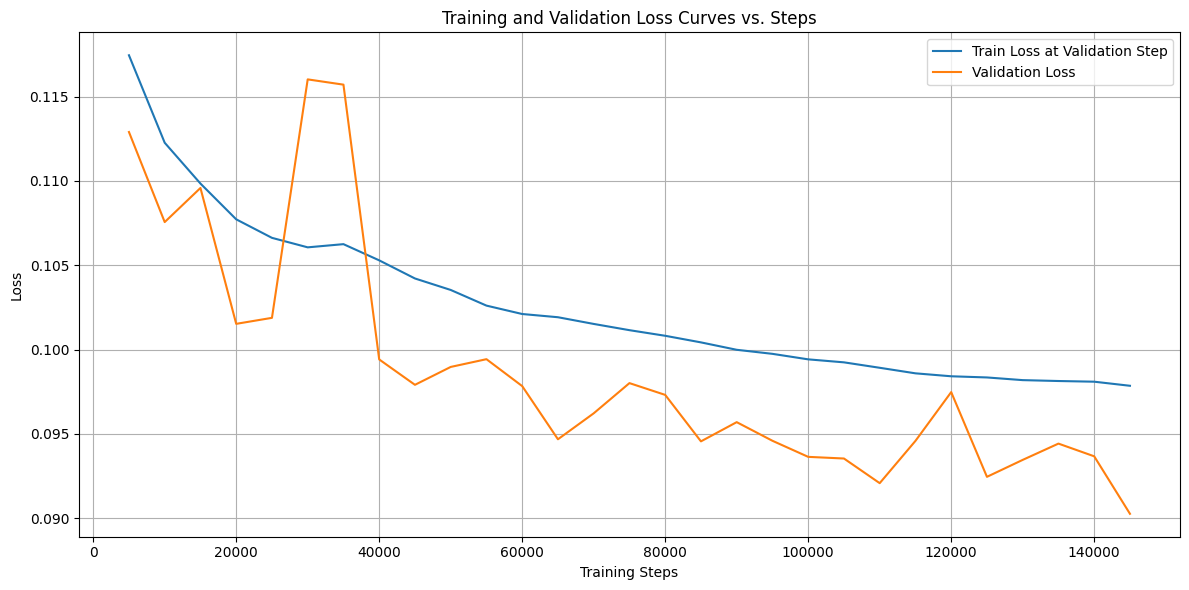

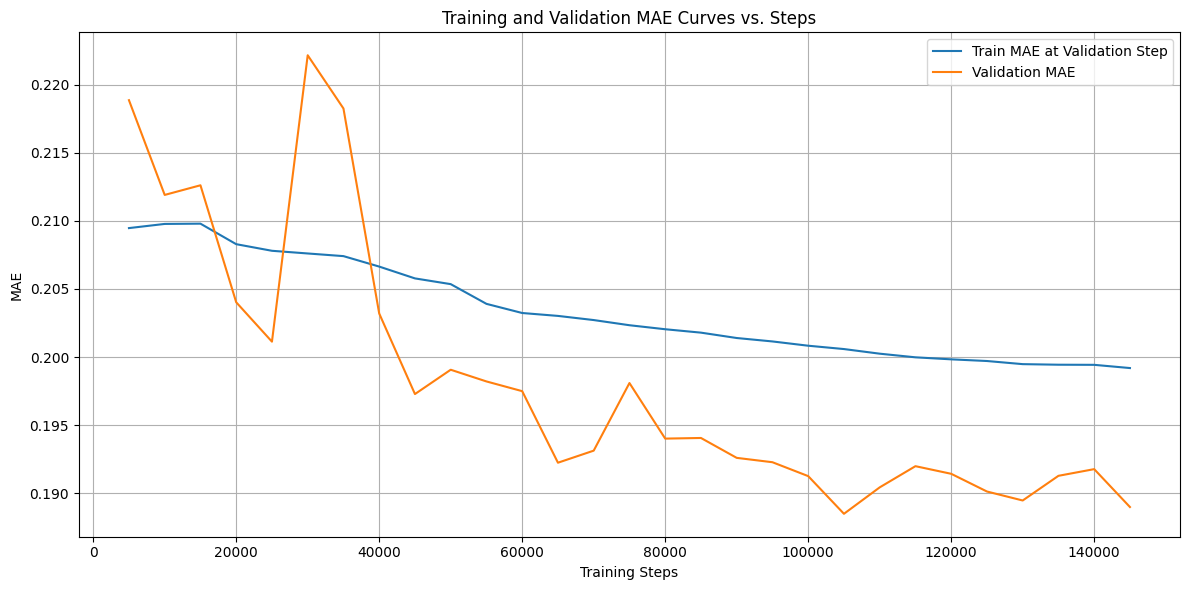

In [25]:
import matplotlib.pyplot as plt

# --- Plotting Loss Curves ---
plt.figure(figsize=(12, 6)) # Set the figure size
# Use steps for the x-axis if you have them, otherwise use range(len(val_losses))
plt.plot(steps, train_losses, label='Train Loss at Validation Step')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves vs. Steps')
plt.legend()
plt.grid(True) # Add a grid for better readability
plt.tight_layout() # Adjust layout

# --- Plotting MAE Curves ---
plt.figure(figsize=(12, 6)) # Set the figure size
# Use steps for the x-axis if you have them, otherwise use range(len(val_maes))
plt.plot(steps, train_maes, label='Train MAE at Validation Step')
plt.plot(steps, val_maes, label='Validation MAE')
plt.xlabel('Training Steps')
plt.ylabel('MAE')
plt.title('Training and Validation MAE Curves vs. Steps')
plt.legend()
plt.grid(True) # Add a grid for better readability
plt.tight_layout() # Adjust layout

In [37]:
def collate_fn(batch):
    batch_fens = [example['fen'] for example in batch]
    labels = torch.tensor(
        [example['target'] for example in batch],
        dtype=torch.float32
    )

    winning_labels = []
    inputs = []

    for example in batch:
        fen = example['fen']
        target = example['target']
        
        # Parse side to move
        stm = fen.split()[1]  # 'w' or 'b'

        # Compute winning label
        if (stm == 'w' and target > 0) or (stm == 'b' and target < 0):
            winning = 1
        else:
            winning = 0

        winning_labels.append(winning)

        # Process input
        inputs.append(torch.tensor(fen_to_token_ids(fen), dtype=torch.long))  # NOTE: long (int64) for token ids

    inputs = torch.stack(inputs)  # Shape: (batch_size, 66)
    winning_labels = torch.tensor(winning_labels, dtype=torch.float32)  # float32 for BCEWithLogitsLoss

    return inputs, labels, winning_labels

train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, collate_fn=collate_fn)

In [38]:
class ChessEvalMultiTaskTransformer(nn.Module):
    def __init__(self, vocab_size=31, d_model=64, n_heads=4, n_layers=3):
        super().__init__()
        seq_len = 64 + 1 + 1  # 64 squares + 1 side-to-move + 1 castling info
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(seq_len, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, n_heads, dim_feedforward=d_model*4, dropout=0.3
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.norm = nn.LayerNorm(d_model)

        # Two heads
        self.reg_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(d_model // 2, 1)
        )
        self.win_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):
        # x: (B, 66)
        B, L = x.size()

        tok_emb = self.embed(x)                    # (B, 66, d_model)
        pos = torch.arange(L, device=x.device)
        pos_emb = self.pos_embed(pos).unsqueeze(0) # (1, 66, d_model)

        h = tok_emb + pos_emb                      # (B, 66, d_model)
        h = self.transformer(h.permute(1, 0, 2))    # (66, B, d_model)
        h = h.mean(dim=0)                           # (B, d_model)
        h = self.norm(h)

        eval_pred = torch.tanh(self.reg_head(h)).squeeze(-1)  # (B,)
        win_pred = self.win_head(h).squeeze(-1)               # (B,) — raw logits (no activation)

        return eval_pred, win_pred

In [42]:
input_tensor = torch.randint(0, 31, (32, 66), dtype=torch.long)

model = ChessEvalMultiTaskTransformer()
output = model(input_tensor)

print(output[0].shape, output[1].shape)

torch.Size([32]) torch.Size([32])


In [45]:
NUM_EPOCHS = 1
total_iters = NUM_EPOCHS * ((num_training_examples // 256) + 1)
print(total_iters)

model = ChessEvalMultiTaskTransformer(d_model = 128, n_heads = 4, n_layers = 4).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=2e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=total_iters, eta_min=5e-5)
eval_criterion = nn.MSELoss()
win_criterion = nn.BCEWithLogitsLoss()

229688


In [46]:
best_val_loss = float('inf')
best_val_mae = float('inf')
num_iterations = 0
patience_counter = 0

PATIENCE = 30000
MIN_IMPROVEMENT = 5e-4
VAL_ITERS = 5000
LOG_ITERS = 1000

early_stop = False

steps = []
train_losses, train_maes, train_win_accs = [], [], []
val_losses, val_maes, val_win_accs = [], [], []

for epoch in range(1, NUM_EPOCHS + 1):
    if early_stop:
        break

    model.train()
    total_loss = 0.0
    total_mae = 0.0
    total_win_correct = 0
    total_samples = 0

    for inputs, labels, winning_labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        inputs, labels, winning_labels = inputs.to(DEVICE), labels.to(DEVICE), winning_labels.to(DEVICE)

        optimizer.zero_grad()
        eval_pred, win_pred = model(inputs)

        loss_eval = eval_criterion(eval_pred.squeeze(), labels)
        loss_win = win_criterion(win_pred.squeeze(), winning_labels)

        loss = loss_eval + loss_win

        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_loss = loss.item()
        batch_mae = torch.mean(torch.abs(eval_pred.squeeze() - labels)).item()

        # Calculate batch binary accuracy
        win_pred_labels = (torch.sigmoid(win_pred.squeeze()) > 0.5).float()
        batch_win_acc = (win_pred_labels == winning_labels).float().mean().item()

        total_loss += batch_loss * inputs.size(0)
        total_mae += batch_mae * inputs.size(0)
        total_win_correct += (win_pred_labels == winning_labels).sum().item()
        total_samples += inputs.size(0)
        num_iterations += 1

        if num_iterations % LOG_ITERS == 0:
            avg_train_loss = total_loss / total_samples
            avg_train_mae = total_mae / total_samples
            avg_train_win_acc = total_win_correct / total_samples

            print(f"Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}, train_win_acc: {avg_train_win_acc:.4f}")

    # Validation every VAL_ITERS iterations
        if num_iterations % VAL_ITERS == 0:
            model.eval()
            val_loss_sum = 0.0
            val_mae_sum = 0.0
            val_win_correct = 0
            val_total_samples = 0

            with torch.no_grad():
                for val_inputs, val_labels, val_winning_labels in val_loader:
                    val_inputs, val_labels, val_winning_labels = val_inputs.to(DEVICE), val_labels.to(DEVICE), val_winning_labels.to(DEVICE)

                    val_pred, val_win_pred = model(val_inputs)

                    val_loss = eval_criterion(val_pred.squeeze(), val_labels)
                    val_mae = torch.mean(torch.abs(val_pred.squeeze() - val_labels))

                    val_loss_sum += val_loss.item() * val_inputs.size(0)
                    val_mae_sum += val_mae.item() * val_inputs.size(0)

                    val_win_preds = (torch.sigmoid(val_win_pred.squeeze()) > 0.5).float()
                    val_win_correct += (val_win_preds == val_winning_labels).sum().item()

                    val_total_samples += val_inputs.size(0)

            avg_val_loss = val_loss_sum / val_total_samples
            avg_val_mae = val_mae_sum / val_total_samples
            avg_val_win_acc = val_win_correct / val_total_samples

            avg_train_loss = total_loss / total_samples
            avg_train_mae = total_mae / total_samples
            avg_train_win_acc = total_win_correct / total_samples

            print(f"\n[Validation] Step {num_iterations} — train_loss: {avg_train_loss:.4f}, train_mae: {avg_train_mae:.4f}, train_win_acc: {avg_train_win_acc:.4f}, val_loss: {avg_val_loss:.4f}, val_mae: {avg_val_mae:.4f}, val_win_acc: {avg_val_win_acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

            steps.append(num_iterations)
            train_losses.append(avg_train_loss)
            train_maes.append(avg_train_mae)
            train_win_accs.append(avg_train_win_acc)

            val_losses.append(avg_val_loss)
            val_maes.append(avg_val_mae)
            val_win_accs.append(avg_val_win_acc)

            # Checkpoint best
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), "best_chess_mlp.pth")
                print(f"Saved new best model after {num_iterations} iters")
            
            # Early stopping on validation MAE
            if avg_val_mae + MIN_IMPROVEMENT < best_val_mae:
                best_val_mae = avg_val_mae
                patience_counter = 0
                print(f"--------Validation MAE improved to {best_val_mae:.6f}--------")
            else:
                patience_counter += VAL_ITERS
                print(f"--------No significant MAE improvement for {patience_counter} iterations--------")

            if patience_counter >= PATIENCE:
                print(f"Early stopping triggered at {num_iterations} iterations (no significant MAE improvement)")
                early_stop = True
                break

            model.train()

Epoch 1: 1011it [00:14, 67.70it/s]

Step 1000 — train_loss: 0.6652, train_mae: 0.2070, train_win_acc: 0.7011


Epoch 1: 2013it [00:29, 67.55it/s]

Step 2000 — train_loss: 0.6397, train_mae: 0.2032, train_win_acc: 0.7207


Epoch 1: 3008it [00:44, 62.76it/s]

Step 3000 — train_loss: 0.6333, train_mae: 0.2013, train_win_acc: 0.7255


Epoch 1: 4011it [01:00, 70.75it/s]

Step 4000 — train_loss: 0.6266, train_mae: 0.1995, train_win_acc: 0.7291


Epoch 1: 4998it [01:15, 67.31it/s]

Step 5000 — train_loss: 0.6212, train_mae: 0.1969, train_win_acc: 0.7312


Epoch 1: 5007it [01:32,  1.64it/s]


[Validation] Step 5000 — train_loss: 0.6212, train_mae: 0.1969, train_win_acc: 0.7312, val_loss: 0.1170, val_mae: 0.2270, val_win_acc: 0.6985, LR: 0.000300
Saved new best model after 5000 iters
--------Validation MAE improved to 0.226951--------


Epoch 1: 6009it [01:47, 62.24it/s]

Step 6000 — train_loss: 0.6185, train_mae: 0.1976, train_win_acc: 0.7336


Epoch 1: 7013it [02:02, 67.74it/s]

Step 7000 — train_loss: 0.6131, train_mae: 0.1939, train_win_acc: 0.7358


Epoch 1: 8007it [02:16, 67.05it/s]

Step 8000 — train_loss: 0.6116, train_mae: 0.1959, train_win_acc: 0.7371


Epoch 1: 9008it [02:31, 67.18it/s]

Step 9000 — train_loss: 0.6112, train_mae: 0.1970, train_win_acc: 0.7376


Epoch 1: 9993it [02:45, 78.66it/s]

Step 10000 — train_loss: 0.6089, train_mae: 0.1973, train_win_acc: 0.7391


Epoch 1: 10007it [03:02,  2.02it/s]


[Validation] Step 10000 — train_loss: 0.6089, train_mae: 0.1973, train_win_acc: 0.7391, val_loss: 0.0983, val_mae: 0.2012, val_win_acc: 0.7286, LR: 0.000299
Saved new best model after 10000 iters
--------Validation MAE improved to 0.201196--------


Epoch 1: 11009it [03:18, 62.01it/s]

Step 11000 — train_loss: 0.6084, train_mae: 0.1971, train_win_acc: 0.7393


Epoch 1: 12015it [03:32, 78.77it/s]

Step 12000 — train_loss: 0.6072, train_mae: 0.1974, train_win_acc: 0.7400


Epoch 1: 13008it [03:47, 67.31it/s]

Step 13000 — train_loss: 0.6058, train_mae: 0.1971, train_win_acc: 0.7406


Epoch 1: 14009it [04:02, 66.81it/s]

Step 14000 — train_loss: 0.6040, train_mae: 0.1970, train_win_acc: 0.7417


Epoch 1: 14996it [04:17, 66.57it/s]

Step 15000 — train_loss: 0.6027, train_mae: 0.1969, train_win_acc: 0.7424


Epoch 1: 15007it [04:34,  1.79it/s]


[Validation] Step 15000 — train_loss: 0.6027, train_mae: 0.1969, train_win_acc: 0.7424, val_loss: 0.1001, val_mae: 0.2036, val_win_acc: 0.7266, LR: 0.000297
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 16007it [04:49, 66.96it/s]

Step 16000 — train_loss: 0.6015, train_mae: 0.1962, train_win_acc: 0.7429


Epoch 1: 17015it [05:03, 78.51it/s]

Step 17000 — train_loss: 0.6001, train_mae: 0.1959, train_win_acc: 0.7437


Epoch 1: 18011it [05:16, 64.69it/s]

Step 18000 — train_loss: 0.5987, train_mae: 0.1955, train_win_acc: 0.7444


Epoch 1: 19009it [05:31, 74.84it/s]

Step 19000 — train_loss: 0.5974, train_mae: 0.1952, train_win_acc: 0.7451


Epoch 1: 19993it [05:45, 66.72it/s]

Step 20000 — train_loss: 0.5957, train_mae: 0.1950, train_win_acc: 0.7461


Epoch 1: 20007it [06:02,  1.92it/s]


[Validation] Step 20000 — train_loss: 0.5957, train_mae: 0.1950, train_win_acc: 0.7461, val_loss: 0.0994, val_mae: 0.1989, val_win_acc: 0.7338, LR: 0.000295
--------Validation MAE improved to 0.198884--------


Epoch 1: 21010it [06:18, 63.52it/s]

Step 21000 — train_loss: 0.5943, train_mae: 0.1947, train_win_acc: 0.7468


Epoch 1: 22009it [06:32, 68.96it/s]

Step 22000 — train_loss: 0.5932, train_mae: 0.1944, train_win_acc: 0.7474


Epoch 1: 23014it [06:45, 78.51it/s]

Step 23000 — train_loss: 0.5925, train_mae: 0.1944, train_win_acc: 0.7479


Epoch 1: 24014it [06:58, 78.45it/s]

Step 24000 — train_loss: 0.5916, train_mae: 0.1942, train_win_acc: 0.7483


Epoch 1: 24992it [07:11, 79.00it/s]

Step 25000 — train_loss: 0.5909, train_mae: 0.1938, train_win_acc: 0.7487


Epoch 1: 25007it [07:28,  2.12it/s]


[Validation] Step 25000 — train_loss: 0.5909, train_mae: 0.1938, train_win_acc: 0.7487, val_loss: 0.0952, val_mae: 0.1912, val_win_acc: 0.7419, LR: 0.000293
Saved new best model after 25000 iters
--------Validation MAE improved to 0.191197--------


Epoch 1: 26011it [07:43, 64.00it/s]

Step 26000 — train_loss: 0.5902, train_mae: 0.1935, train_win_acc: 0.7490


Epoch 1: 27013it [07:58, 67.61it/s]

Step 27000 — train_loss: 0.5888, train_mae: 0.1931, train_win_acc: 0.7498


Epoch 1: 28007it [08:13, 67.29it/s]

Step 28000 — train_loss: 0.5873, train_mae: 0.1928, train_win_acc: 0.7507


Epoch 1: 29013it [08:27, 73.26it/s]

Step 29000 — train_loss: 0.5861, train_mae: 0.1925, train_win_acc: 0.7514


Epoch 1: 29997it [08:41, 68.60it/s]

Step 30000 — train_loss: 0.5827, train_mae: 0.1928, train_win_acc: 0.7541


Epoch 1: 30007it [08:58,  1.70it/s]


[Validation] Step 30000 — train_loss: 0.5827, train_mae: 0.1928, train_win_acc: 0.7541, val_loss: 0.1077, val_mae: 0.2080, val_win_acc: 0.7258, LR: 0.000290
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 31006it [09:12, 66.31it/s]

Step 31000 — train_loss: 0.5816, train_mae: 0.1927, train_win_acc: 0.7549


Epoch 1: 32008it [09:27, 69.52it/s]

Step 32000 — train_loss: 0.5809, train_mae: 0.1927, train_win_acc: 0.7554


Epoch 1: 33012it [09:42, 62.32it/s]

Step 33000 — train_loss: 0.5804, train_mae: 0.1925, train_win_acc: 0.7557


Epoch 1: 34009it [09:58, 62.63it/s]

Step 34000 — train_loss: 0.5797, train_mae: 0.1922, train_win_acc: 0.7561


Epoch 1: 34996it [10:14, 62.72it/s]

Step 35000 — train_loss: 0.5792, train_mae: 0.1922, train_win_acc: 0.7565


Epoch 1: 35007it [10:31,  1.74it/s]


[Validation] Step 35000 — train_loss: 0.5792, train_mae: 0.1922, train_win_acc: 0.7565, val_loss: 0.0938, val_mae: 0.1896, val_win_acc: 0.7487, LR: 0.000286
Saved new best model after 35000 iters
--------Validation MAE improved to 0.189600--------


Epoch 1: 36008it [10:46, 66.68it/s]

Step 36000 — train_loss: 0.5784, train_mae: 0.1919, train_win_acc: 0.7569


Epoch 1: 37012it [11:00, 68.64it/s]

Step 37000 — train_loss: 0.5778, train_mae: 0.1916, train_win_acc: 0.7572


Epoch 1: 38006it [11:15, 62.17it/s]

Step 38000 — train_loss: 0.5765, train_mae: 0.1915, train_win_acc: 0.7579


Epoch 1: 39010it [11:31, 62.64it/s]

Step 39000 — train_loss: 0.5757, train_mae: 0.1912, train_win_acc: 0.7583


Epoch 1: 39997it [11:47, 62.38it/s]

Step 40000 — train_loss: 0.5747, train_mae: 0.1910, train_win_acc: 0.7589


Epoch 1: 40007it [12:04,  1.69it/s]


[Validation] Step 40000 — train_loss: 0.5747, train_mae: 0.1910, train_win_acc: 0.7589, val_loss: 0.0932, val_mae: 0.1920, val_win_acc: 0.7434, LR: 0.000282
Saved new best model after 40000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 41009it [12:19, 62.19it/s]

Step 41000 — train_loss: 0.5736, train_mae: 0.1909, train_win_acc: 0.7596


Epoch 1: 42011it [12:34, 66.87it/s]

Step 42000 — train_loss: 0.5731, train_mae: 0.1905, train_win_acc: 0.7597


Epoch 1: 43013it [12:49, 66.78it/s]

Step 43000 — train_loss: 0.5724, train_mae: 0.1902, train_win_acc: 0.7600


Epoch 1: 44009it [13:03, 66.91it/s]

Step 44000 — train_loss: 0.5717, train_mae: 0.1900, train_win_acc: 0.7604


Epoch 1: 44996it [13:19, 66.38it/s]

Step 45000 — train_loss: 0.5711, train_mae: 0.1897, train_win_acc: 0.7607


Epoch 1: 45008it [13:36,  1.84it/s]


[Validation] Step 45000 — train_loss: 0.5711, train_mae: 0.1897, train_win_acc: 0.7607, val_loss: 0.0895, val_mae: 0.1872, val_win_acc: 0.7540, LR: 0.000277
Saved new best model after 45000 iters
--------Validation MAE improved to 0.187189--------


Epoch 1: 46009it [13:51, 66.57it/s]

Step 46000 — train_loss: 0.5706, train_mae: 0.1895, train_win_acc: 0.7609


Epoch 1: 47009it [14:06, 68.02it/s]

Step 47000 — train_loss: 0.5700, train_mae: 0.1893, train_win_acc: 0.7612


Epoch 1: 48012it [14:22, 62.44it/s]

Step 48000 — train_loss: 0.5697, train_mae: 0.1892, train_win_acc: 0.7613


Epoch 1: 49006it [14:37, 63.78it/s]

Step 49000 — train_loss: 0.5690, train_mae: 0.1890, train_win_acc: 0.7617


Epoch 1: 49997it [14:52, 63.78it/s]

Step 50000 — train_loss: 0.5687, train_mae: 0.1889, train_win_acc: 0.7619


Epoch 1: 50007it [15:09,  1.68it/s]


[Validation] Step 50000 — train_loss: 0.5687, train_mae: 0.1889, train_win_acc: 0.7619, val_loss: 0.0894, val_mae: 0.1874, val_win_acc: 0.7540, LR: 0.000272
Saved new best model after 50000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 51007it [15:24, 61.88it/s]

Step 51000 — train_loss: 0.5680, train_mae: 0.1886, train_win_acc: 0.7623


Epoch 1: 52009it [15:39, 67.11it/s]

Step 52000 — train_loss: 0.5672, train_mae: 0.1882, train_win_acc: 0.7626


Epoch 1: 53010it [15:55, 60.57it/s]

Step 53000 — train_loss: 0.5666, train_mae: 0.1880, train_win_acc: 0.7630


Epoch 1: 54011it [16:11, 60.43it/s]

Step 54000 — train_loss: 0.5657, train_mae: 0.1873, train_win_acc: 0.7634


Epoch 1: 54995it [16:26, 67.28it/s]

Step 55000 — train_loss: 0.5643, train_mae: 0.1872, train_win_acc: 0.7643


Epoch 1: 55007it [16:43,  1.81it/s]


[Validation] Step 55000 — train_loss: 0.5643, train_mae: 0.1872, train_win_acc: 0.7643, val_loss: 0.0984, val_mae: 0.1925, val_win_acc: 0.7457, LR: 0.000266
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 56007it [16:58, 66.12it/s]

Step 56000 — train_loss: 0.5637, train_mae: 0.1871, train_win_acc: 0.7647


Epoch 1: 57011it [17:12, 67.35it/s]

Step 57000 — train_loss: 0.5631, train_mae: 0.1868, train_win_acc: 0.7649


Epoch 1: 58007it [17:27, 67.47it/s]

Step 58000 — train_loss: 0.5627, train_mae: 0.1864, train_win_acc: 0.7650


Epoch 1: 59008it [17:41, 78.69it/s]

Step 59000 — train_loss: 0.5624, train_mae: 0.1864, train_win_acc: 0.7652


Epoch 1: 59999it [17:57, 72.35it/s]

Step 60000 — train_loss: 0.5621, train_mae: 0.1863, train_win_acc: 0.7655


Epoch 1: 60007it [18:14,  1.68it/s]


[Validation] Step 60000 — train_loss: 0.5621, train_mae: 0.1863, train_win_acc: 0.7655, val_loss: 0.0957, val_mae: 0.1910, val_win_acc: 0.7553, LR: 0.000260
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 61012it [18:29, 64.47it/s]

Step 61000 — train_loss: 0.5616, train_mae: 0.1862, train_win_acc: 0.7657


Epoch 1: 62014it [18:44, 76.38it/s]

Step 62000 — train_loss: 0.5613, train_mae: 0.1861, train_win_acc: 0.7659


Epoch 1: 63011it [18:58, 64.90it/s]

Step 63000 — train_loss: 0.5608, train_mae: 0.1860, train_win_acc: 0.7662


Epoch 1: 64009it [19:12, 78.02it/s]

Step 64000 — train_loss: 0.5606, train_mae: 0.1859, train_win_acc: 0.7664


Epoch 1: 64997it [19:26, 68.26it/s]

Step 65000 — train_loss: 0.5603, train_mae: 0.1858, train_win_acc: 0.7665


Epoch 1: 65007it [19:43,  1.71it/s]


[Validation] Step 65000 — train_loss: 0.5603, train_mae: 0.1858, train_win_acc: 0.7665, val_loss: 0.0877, val_mae: 0.1826, val_win_acc: 0.7551, LR: 0.000254
Saved new best model after 65000 iters
--------Validation MAE improved to 0.182594--------


Epoch 1: 66013it [19:58, 75.18it/s]

Step 66000 — train_loss: 0.5599, train_mae: 0.1856, train_win_acc: 0.7667


Epoch 1: 67008it [20:12, 63.18it/s]

Step 67000 — train_loss: 0.5594, train_mae: 0.1855, train_win_acc: 0.7670


Epoch 1: 68012it [20:27, 75.03it/s]

Step 68000 — train_loss: 0.5589, train_mae: 0.1853, train_win_acc: 0.7672


Epoch 1: 69015it [20:41, 72.23it/s]

Step 69000 — train_loss: 0.5587, train_mae: 0.1853, train_win_acc: 0.7673


Epoch 1: 69998it [20:55, 78.74it/s]

Step 70000 — train_loss: 0.5583, train_mae: 0.1851, train_win_acc: 0.7675


Epoch 1: 70008it [21:12,  1.83it/s]


[Validation] Step 70000 — train_loss: 0.5583, train_mae: 0.1851, train_win_acc: 0.7675, val_loss: 0.0908, val_mae: 0.1832, val_win_acc: 0.7581, LR: 0.000247
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 71007it [21:26, 67.64it/s]

Step 71000 — train_loss: 0.5578, train_mae: 0.1849, train_win_acc: 0.7677


Epoch 1: 72014it [21:41, 71.68it/s]

Step 72000 — train_loss: 0.5572, train_mae: 0.1847, train_win_acc: 0.7680


Epoch 1: 73007it [21:55, 67.63it/s]

Step 73000 — train_loss: 0.5568, train_mae: 0.1846, train_win_acc: 0.7682


Epoch 1: 74012it [22:11, 63.91it/s]

Step 74000 — train_loss: 0.5565, train_mae: 0.1846, train_win_acc: 0.7684


Epoch 1: 74998it [22:26, 67.85it/s]

Step 75000 — train_loss: 0.5560, train_mae: 0.1845, train_win_acc: 0.7687


Epoch 1: 75007it [22:43,  1.71it/s]


[Validation] Step 75000 — train_loss: 0.5560, train_mae: 0.1845, train_win_acc: 0.7687, val_loss: 0.0932, val_mae: 0.1883, val_win_acc: 0.7586, LR: 0.000240
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 76006it [22:58, 64.09it/s]

Step 76000 — train_loss: 0.5557, train_mae: 0.1845, train_win_acc: 0.7689


Epoch 1: 77010it [23:14, 62.44it/s]

Step 77000 — train_loss: 0.5552, train_mae: 0.1843, train_win_acc: 0.7691


Epoch 1: 78011it [23:30, 67.26it/s]

Step 78000 — train_loss: 0.5547, train_mae: 0.1842, train_win_acc: 0.7694


Epoch 1: 79010it [23:45, 78.16it/s]

Step 79000 — train_loss: 0.5543, train_mae: 0.1841, train_win_acc: 0.7696


Epoch 1: 79998it [23:59, 64.45it/s]

Step 80000 — train_loss: 0.5538, train_mae: 0.1839, train_win_acc: 0.7698


Epoch 1: 80007it [24:16,  1.68it/s]


[Validation] Step 80000 — train_loss: 0.5538, train_mae: 0.1839, train_win_acc: 0.7698, val_loss: 0.0959, val_mae: 0.1883, val_win_acc: 0.7606, LR: 0.000232
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 81008it [24:32, 61.61it/s]

Step 81000 — train_loss: 0.5532, train_mae: 0.1837, train_win_acc: 0.7701


Epoch 1: 82009it [24:47, 66.84it/s]

Step 82000 — train_loss: 0.5528, train_mae: 0.1836, train_win_acc: 0.7703


Epoch 1: 83010it [25:03, 62.35it/s]

Step 83000 — train_loss: 0.5524, train_mae: 0.1834, train_win_acc: 0.7705


Epoch 1: 84010it [25:18, 63.24it/s]

Step 84000 — train_loss: 0.5520, train_mae: 0.1834, train_win_acc: 0.7707


Epoch 1: 84997it [25:33, 67.21it/s]

Step 85000 — train_loss: 0.5517, train_mae: 0.1833, train_win_acc: 0.7709


Epoch 1: 85007it [25:50,  1.70it/s]


[Validation] Step 85000 — train_loss: 0.5517, train_mae: 0.1833, train_win_acc: 0.7709, val_loss: 0.0882, val_mae: 0.1816, val_win_acc: 0.7632, LR: 0.000225
--------Validation MAE improved to 0.181603--------


Epoch 1: 86011it [26:05, 62.13it/s]

Step 86000 — train_loss: 0.5513, train_mae: 0.1832, train_win_acc: 0.7711


Epoch 1: 87010it [26:21, 74.07it/s]

Step 87000 — train_loss: 0.5509, train_mae: 0.1831, train_win_acc: 0.7713


Epoch 1: 88007it [26:37, 63.66it/s]

Step 88000 — train_loss: 0.5505, train_mae: 0.1829, train_win_acc: 0.7715


Epoch 1: 89011it [26:52, 67.53it/s]

Step 89000 — train_loss: 0.5498, train_mae: 0.1827, train_win_acc: 0.7719


Epoch 1: 89999it [27:07, 66.96it/s]

Step 90000 — train_loss: 0.5494, train_mae: 0.1826, train_win_acc: 0.7721


Epoch 1: 90007it [27:24,  1.59it/s]


[Validation] Step 90000 — train_loss: 0.5494, train_mae: 0.1826, train_win_acc: 0.7721, val_loss: 0.0907, val_mae: 0.1828, val_win_acc: 0.7637, LR: 0.000217
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 91007it [27:40, 52.86it/s]

Step 91000 — train_loss: 0.5490, train_mae: 0.1825, train_win_acc: 0.7723


Epoch 1: 92013it [27:57, 76.93it/s]

Step 92000 — train_loss: 0.5485, train_mae: 0.1824, train_win_acc: 0.7725


Epoch 1: 93007it [28:12, 58.05it/s]

Step 93000 — train_loss: 0.5482, train_mae: 0.1823, train_win_acc: 0.7727


Epoch 1: 94011it [28:29, 56.22it/s]

Step 94000 — train_loss: 0.5480, train_mae: 0.1822, train_win_acc: 0.7728


Epoch 1: 94999it [28:44, 65.14it/s]

Step 95000 — train_loss: 0.5478, train_mae: 0.1821, train_win_acc: 0.7729


Epoch 1: 95006it [29:02,  1.47it/s]


[Validation] Step 95000 — train_loss: 0.5478, train_mae: 0.1821, train_win_acc: 0.7729, val_loss: 0.0893, val_mae: 0.1831, val_win_acc: 0.7600, LR: 0.000209
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 96012it [29:18, 61.61it/s]

Step 96000 — train_loss: 0.5475, train_mae: 0.1820, train_win_acc: 0.7731


Epoch 1: 97013it [29:33, 67.03it/s]

Step 97000 — train_loss: 0.5471, train_mae: 0.1819, train_win_acc: 0.7733


Epoch 1: 98009it [29:48, 70.30it/s]

Step 98000 — train_loss: 0.5466, train_mae: 0.1818, train_win_acc: 0.7735


Epoch 1: 99011it [30:03, 66.78it/s]

Step 99000 — train_loss: 0.5463, train_mae: 0.1816, train_win_acc: 0.7737


Epoch 1: 99999it [30:18, 61.91it/s]

Step 100000 — train_loss: 0.5459, train_mae: 0.1815, train_win_acc: 0.7739


Epoch 1: 100008it [30:35,  1.66it/s]


[Validation] Step 100000 — train_loss: 0.5459, train_mae: 0.1815, train_win_acc: 0.7739, val_loss: 0.0895, val_mae: 0.1839, val_win_acc: 0.7653, LR: 0.000200
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 101006it [30:51, 62.94it/s]

Step 101000 — train_loss: 0.5454, train_mae: 0.1814, train_win_acc: 0.7741


Epoch 1: 102008it [31:07, 63.50it/s]

Step 102000 — train_loss: 0.5450, train_mae: 0.1813, train_win_acc: 0.7744


Epoch 1: 103012it [31:22, 67.18it/s]

Step 103000 — train_loss: 0.5446, train_mae: 0.1812, train_win_acc: 0.7746


Epoch 1: 104011it [31:37, 65.76it/s]

Step 104000 — train_loss: 0.5442, train_mae: 0.1811, train_win_acc: 0.7748


Epoch 1: 104995it [31:51, 66.95it/s]

Step 105000 — train_loss: 0.5439, train_mae: 0.1811, train_win_acc: 0.7750


Epoch 1: 105007it [32:08,  1.79it/s]


[Validation] Step 105000 — train_loss: 0.5439, train_mae: 0.1811, train_win_acc: 0.7750, val_loss: 0.0923, val_mae: 0.1836, val_win_acc: 0.7628, LR: 0.000192
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 106010it [32:23, 66.77it/s]

Step 106000 — train_loss: 0.5436, train_mae: 0.1810, train_win_acc: 0.7751


Epoch 1: 107008it [32:38, 66.51it/s]

Step 107000 — train_loss: 0.5433, train_mae: 0.1809, train_win_acc: 0.7752


Epoch 1: 108010it [32:54, 61.62it/s]

Step 108000 — train_loss: 0.5431, train_mae: 0.1807, train_win_acc: 0.7754


Epoch 1: 109012it [33:09, 67.15it/s]

Step 109000 — train_loss: 0.5427, train_mae: 0.1806, train_win_acc: 0.7755


Epoch 1: 109998it [33:24, 61.64it/s]

Step 110000 — train_loss: 0.5425, train_mae: 0.1805, train_win_acc: 0.7756


Epoch 1: 110007it [33:41,  1.63it/s]


[Validation] Step 110000 — train_loss: 0.5425, train_mae: 0.1805, train_win_acc: 0.7756, val_loss: 0.0852, val_mae: 0.1783, val_win_acc: 0.7654, LR: 0.000183
Saved new best model after 110000 iters
--------Validation MAE improved to 0.178339--------


Epoch 1: 111008it [33:57, 63.71it/s]

Step 111000 — train_loss: 0.5421, train_mae: 0.1804, train_win_acc: 0.7758


Epoch 1: 112010it [34:13, 60.89it/s]

Step 112000 — train_loss: 0.5417, train_mae: 0.1803, train_win_acc: 0.7760


Epoch 1: 113009it [34:29, 66.59it/s]

Step 113000 — train_loss: 0.5415, train_mae: 0.1802, train_win_acc: 0.7761


Epoch 1: 114013it [34:44, 63.86it/s]

Step 114000 — train_loss: 0.5412, train_mae: 0.1801, train_win_acc: 0.7763


Epoch 1: 114997it [34:59, 66.28it/s]

Step 115000 — train_loss: 0.5409, train_mae: 0.1800, train_win_acc: 0.7764


Epoch 1: 115007it [35:16,  1.69it/s]


[Validation] Step 115000 — train_loss: 0.5409, train_mae: 0.1800, train_win_acc: 0.7764, val_loss: 0.0877, val_mae: 0.1801, val_win_acc: 0.7703, LR: 0.000175
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 116007it [35:31, 67.20it/s]

Step 116000 — train_loss: 0.5407, train_mae: 0.1799, train_win_acc: 0.7765


Epoch 1: 117014it [35:46, 73.98it/s]

Step 117000 — train_loss: 0.5404, train_mae: 0.1798, train_win_acc: 0.7767


Epoch 1: 118006it [36:01, 61.86it/s]

Step 118000 — train_loss: 0.5402, train_mae: 0.1798, train_win_acc: 0.7768


Epoch 1: 119008it [36:16, 66.67it/s]

Step 119000 — train_loss: 0.5400, train_mae: 0.1797, train_win_acc: 0.7769


Epoch 1: 119998it [36:32, 67.52it/s]

Step 120000 — train_loss: 0.5398, train_mae: 0.1797, train_win_acc: 0.7770


Epoch 1: 120007it [36:49,  1.65it/s]


[Validation] Step 120000 — train_loss: 0.5398, train_mae: 0.1797, train_win_acc: 0.7770, val_loss: 0.0919, val_mae: 0.1814, val_win_acc: 0.7704, LR: 0.000166
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 121007it [37:04, 67.06it/s]

Step 121000 — train_loss: 0.5396, train_mae: 0.1796, train_win_acc: 0.7771


Epoch 1: 122009it [37:19, 66.14it/s]

Step 122000 — train_loss: 0.5394, train_mae: 0.1796, train_win_acc: 0.7772


Epoch 1: 123006it [37:34, 62.52it/s]

Step 123000 — train_loss: 0.5392, train_mae: 0.1795, train_win_acc: 0.7773


Epoch 1: 124013it [37:49, 66.85it/s]

Step 124000 — train_loss: 0.5390, train_mae: 0.1794, train_win_acc: 0.7774


Epoch 1: 124993it [38:04, 67.28it/s]

Step 125000 — train_loss: 0.5387, train_mae: 0.1794, train_win_acc: 0.7776


Epoch 1: 125007it [38:21,  1.93it/s]


[Validation] Step 125000 — train_loss: 0.5387, train_mae: 0.1794, train_win_acc: 0.7776, val_loss: 0.0860, val_mae: 0.1780, val_win_acc: 0.7684, LR: 0.000158
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 126009it [38:36, 67.72it/s]

Step 126000 — train_loss: 0.5384, train_mae: 0.1793, train_win_acc: 0.7777


Epoch 1: 127010it [38:51, 66.81it/s]

Step 127000 — train_loss: 0.5382, train_mae: 0.1792, train_win_acc: 0.7778


Epoch 1: 128006it [39:05, 73.38it/s]

Step 128000 — train_loss: 0.5379, train_mae: 0.1791, train_win_acc: 0.7780


Epoch 1: 129010it [39:20, 66.88it/s]

Step 129000 — train_loss: 0.5377, train_mae: 0.1790, train_win_acc: 0.7781


Epoch 1: 129996it [39:34, 66.92it/s]

Step 130000 — train_loss: 0.5373, train_mae: 0.1789, train_win_acc: 0.7783


Epoch 1: 130007it [39:51,  1.73it/s]


[Validation] Step 130000 — train_loss: 0.5373, train_mae: 0.1789, train_win_acc: 0.7783, val_loss: 0.0881, val_mae: 0.1794, val_win_acc: 0.7682, LR: 0.000149
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 131010it [40:05, 78.82it/s]

Step 131000 — train_loss: 0.5370, train_mae: 0.1789, train_win_acc: 0.7785


Epoch 1: 132008it [40:19, 67.07it/s]

Step 132000 — train_loss: 0.5368, train_mae: 0.1788, train_win_acc: 0.7786


Epoch 1: 133007it [40:33, 65.87it/s]

Step 133000 — train_loss: 0.5366, train_mae: 0.1788, train_win_acc: 0.7787


Epoch 1: 134009it [40:48, 62.42it/s]

Step 134000 — train_loss: 0.5364, train_mae: 0.1787, train_win_acc: 0.7788


Epoch 1: 134996it [41:03, 62.64it/s]

Step 135000 — train_loss: 0.5361, train_mae: 0.1787, train_win_acc: 0.7789


Epoch 1: 135007it [41:20,  1.76it/s]


[Validation] Step 135000 — train_loss: 0.5361, train_mae: 0.1787, train_win_acc: 0.7789, val_loss: 0.0908, val_mae: 0.1829, val_win_acc: 0.7721, LR: 0.000141
--------No significant MAE improvement for 25000 iterations--------


Epoch 1: 136010it [41:36, 64.50it/s]

Step 136000 — train_loss: 0.5360, train_mae: 0.1787, train_win_acc: 0.7790


Epoch 1: 137008it [41:52, 64.24it/s]

Step 137000 — train_loss: 0.5357, train_mae: 0.1786, train_win_acc: 0.7792


Epoch 1: 138006it [42:08, 62.55it/s]

Step 138000 — train_loss: 0.5356, train_mae: 0.1786, train_win_acc: 0.7793


Epoch 1: 139007it [42:23, 67.30it/s]

Step 139000 — train_loss: 0.5354, train_mae: 0.1785, train_win_acc: 0.7794


Epoch 1: 139996it [42:37, 67.27it/s]

Step 140000 — train_loss: 0.5352, train_mae: 0.1785, train_win_acc: 0.7795


Epoch 1: 140008it [42:55,  1.79it/s]


[Validation] Step 140000 — train_loss: 0.5352, train_mae: 0.1785, train_win_acc: 0.7795, val_loss: 0.0844, val_mae: 0.1755, val_win_acc: 0.7773, LR: 0.000133
Saved new best model after 140000 iters
--------Validation MAE improved to 0.175525--------


Epoch 1: 141013it [43:10, 66.86it/s]

Step 141000 — train_loss: 0.5349, train_mae: 0.1784, train_win_acc: 0.7796


Epoch 1: 142009it [43:24, 61.42it/s]

Step 142000 — train_loss: 0.5346, train_mae: 0.1783, train_win_acc: 0.7797


Epoch 1: 143009it [43:40, 64.15it/s]

Step 143000 — train_loss: 0.5344, train_mae: 0.1782, train_win_acc: 0.7798


Epoch 1: 144009it [43:56, 64.36it/s]

Step 144000 — train_loss: 0.5341, train_mae: 0.1781, train_win_acc: 0.7799


Epoch 1: 144993it [44:11, 67.29it/s]

Step 145000 — train_loss: 0.5339, train_mae: 0.1780, train_win_acc: 0.7800


Epoch 1: 145007it [44:28,  1.91it/s]


[Validation] Step 145000 — train_loss: 0.5339, train_mae: 0.1780, train_win_acc: 0.7800, val_loss: 0.0836, val_mae: 0.1757, val_win_acc: 0.7773, LR: 0.000125
Saved new best model after 145000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 146011it [44:44, 62.73it/s]

Step 146000 — train_loss: 0.5337, train_mae: 0.1780, train_win_acc: 0.7802


Epoch 1: 147009it [44:59, 66.48it/s]

Step 147000 — train_loss: 0.5335, train_mae: 0.1779, train_win_acc: 0.7803


Epoch 1: 148013it [45:14, 66.87it/s]

Step 148000 — train_loss: 0.5334, train_mae: 0.1779, train_win_acc: 0.7803


Epoch 1: 149009it [45:28, 78.65it/s]

Step 149000 — train_loss: 0.5332, train_mae: 0.1778, train_win_acc: 0.7804


Epoch 1: 149997it [45:42, 67.05it/s]

Step 150000 — train_loss: 0.5330, train_mae: 0.1778, train_win_acc: 0.7805


Epoch 1: 150007it [45:59,  1.70it/s]


[Validation] Step 150000 — train_loss: 0.5330, train_mae: 0.1778, train_win_acc: 0.7805, val_loss: 0.0828, val_mae: 0.1722, val_win_acc: 0.7736, LR: 0.000117
Saved new best model after 150000 iters
--------Validation MAE improved to 0.172178--------


Epoch 1: 151010it [46:13, 78.43it/s]

Step 151000 — train_loss: 0.5328, train_mae: 0.1777, train_win_acc: 0.7806


Epoch 1: 152012it [46:28, 70.56it/s]

Step 152000 — train_loss: 0.5326, train_mae: 0.1776, train_win_acc: 0.7807


Epoch 1: 153008it [46:44, 65.61it/s]

Step 153000 — train_loss: 0.5323, train_mae: 0.1775, train_win_acc: 0.7809


Epoch 1: 154010it [46:59, 65.38it/s]

Step 154000 — train_loss: 0.5322, train_mae: 0.1774, train_win_acc: 0.7809


Epoch 1: 154993it [47:14, 63.97it/s]

Step 155000 — train_loss: 0.5320, train_mae: 0.1774, train_win_acc: 0.7810


Epoch 1: 155007it [47:31,  1.92it/s]


[Validation] Step 155000 — train_loss: 0.5320, train_mae: 0.1774, train_win_acc: 0.7810, val_loss: 0.0815, val_mae: 0.1733, val_win_acc: 0.7793, LR: 0.000110
Saved new best model after 155000 iters
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 156008it [47:47, 59.99it/s]

Step 156000 — train_loss: 0.5318, train_mae: 0.1773, train_win_acc: 0.7811


Epoch 1: 157011it [48:02, 66.79it/s]

Step 157000 — train_loss: 0.5316, train_mae: 0.1773, train_win_acc: 0.7812


Epoch 1: 158009it [48:17, 67.20it/s]

Step 158000 — train_loss: 0.5315, train_mae: 0.1772, train_win_acc: 0.7813


Epoch 1: 159010it [48:32, 66.44it/s]

Step 159000 — train_loss: 0.5313, train_mae: 0.1771, train_win_acc: 0.7814


Epoch 1: 159993it [48:47, 64.98it/s]

Step 160000 — train_loss: 0.5312, train_mae: 0.1771, train_win_acc: 0.7814


Epoch 1: 160006it [49:04,  1.87it/s]


[Validation] Step 160000 — train_loss: 0.5312, train_mae: 0.1771, train_win_acc: 0.7814, val_loss: 0.0837, val_mae: 0.1743, val_win_acc: 0.7776, LR: 0.000103
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 161010it [49:19, 66.96it/s]

Step 161000 — train_loss: 0.5310, train_mae: 0.1770, train_win_acc: 0.7815


Epoch 1: 162006it [49:35, 62.39it/s]

Step 162000 — train_loss: 0.5309, train_mae: 0.1770, train_win_acc: 0.7816


Epoch 1: 163008it [49:50, 66.97it/s]

Step 163000 — train_loss: 0.5307, train_mae: 0.1769, train_win_acc: 0.7817


Epoch 1: 164010it [50:04, 78.98it/s]

Step 164000 — train_loss: 0.5305, train_mae: 0.1768, train_win_acc: 0.7818


Epoch 1: 164996it [50:19, 62.16it/s]

Step 165000 — train_loss: 0.5303, train_mae: 0.1768, train_win_acc: 0.7819


Epoch 1: 165007it [50:36,  1.76it/s]


[Validation] Step 165000 — train_loss: 0.5303, train_mae: 0.1768, train_win_acc: 0.7819, val_loss: 0.0858, val_mae: 0.1763, val_win_acc: 0.7748, LR: 0.000096
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 166008it [50:52, 61.45it/s]

Step 166000 — train_loss: 0.5302, train_mae: 0.1767, train_win_acc: 0.7820


Epoch 1: 167008it [51:08, 71.43it/s]

Step 167000 — train_loss: 0.5300, train_mae: 0.1767, train_win_acc: 0.7820


Epoch 1: 168011it [51:23, 66.89it/s]

Step 168000 — train_loss: 0.5298, train_mae: 0.1766, train_win_acc: 0.7822


Epoch 1: 169009it [51:37, 78.37it/s]

Step 169000 — train_loss: 0.5296, train_mae: 0.1765, train_win_acc: 0.7822


Epoch 1: 169995it [51:50, 67.51it/s]

Step 170000 — train_loss: 0.5293, train_mae: 0.1764, train_win_acc: 0.7823


Epoch 1: 170007it [52:08,  1.82it/s]


[Validation] Step 170000 — train_loss: 0.5293, train_mae: 0.1764, train_win_acc: 0.7823, val_loss: 0.0849, val_mae: 0.1731, val_win_acc: 0.7798, LR: 0.000089
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 171009it [52:23, 62.38it/s]

Step 171000 — train_loss: 0.5291, train_mae: 0.1763, train_win_acc: 0.7824


Epoch 1: 172012it [52:38, 63.25it/s]

Step 172000 — train_loss: 0.5289, train_mae: 0.1763, train_win_acc: 0.7825


Epoch 1: 173008it [52:53, 66.30it/s]

Step 173000 — train_loss: 0.5288, train_mae: 0.1762, train_win_acc: 0.7826


Epoch 1: 174010it [53:09, 67.16it/s]

Step 174000 — train_loss: 0.5286, train_mae: 0.1761, train_win_acc: 0.7827


Epoch 1: 174999it [53:23, 75.79it/s]

Step 175000 — train_loss: 0.5285, train_mae: 0.1761, train_win_acc: 0.7828


Epoch 1: 175007it [53:40,  1.72it/s]


[Validation] Step 175000 — train_loss: 0.5285, train_mae: 0.1761, train_win_acc: 0.7828, val_loss: 0.0823, val_mae: 0.1724, val_win_acc: 0.7811, LR: 0.000083
--------No significant MAE improvement for 25000 iterations--------


Epoch 1: 176010it [53:55, 74.00it/s]

Step 176000 — train_loss: 0.5283, train_mae: 0.1760, train_win_acc: 0.7828


Epoch 1: 177008it [54:10, 65.22it/s]

Step 177000 — train_loss: 0.5281, train_mae: 0.1760, train_win_acc: 0.7829


Epoch 1: 178008it [54:24, 77.04it/s]

Step 178000 — train_loss: 0.5280, train_mae: 0.1759, train_win_acc: 0.7830


Epoch 1: 179012it [54:39, 78.17it/s]

Step 179000 — train_loss: 0.5279, train_mae: 0.1759, train_win_acc: 0.7830


Epoch 1: 179992it [54:53, 69.47it/s]

Step 180000 — train_loss: 0.5277, train_mae: 0.1758, train_win_acc: 0.7831


Epoch 1: 180007it [55:10,  2.05it/s]


[Validation] Step 180000 — train_loss: 0.5277, train_mae: 0.1758, train_win_acc: 0.7831, val_loss: 0.0804, val_mae: 0.1699, val_win_acc: 0.7826, LR: 0.000078
Saved new best model after 180000 iters
--------Validation MAE improved to 0.169874--------


Epoch 1: 181012it [55:26, 65.07it/s]

Step 181000 — train_loss: 0.5276, train_mae: 0.1758, train_win_acc: 0.7832


Epoch 1: 182010it [55:41, 64.43it/s]

Step 182000 — train_loss: 0.5274, train_mae: 0.1758, train_win_acc: 0.7833


Epoch 1: 183013it [55:56, 78.43it/s]

Step 183000 — train_loss: 0.5273, train_mae: 0.1757, train_win_acc: 0.7833


Epoch 1: 184013it [56:09, 75.68it/s]

Step 184000 — train_loss: 0.5271, train_mae: 0.1756, train_win_acc: 0.7834


Epoch 1: 184993it [56:24, 67.13it/s]

Step 185000 — train_loss: 0.5269, train_mae: 0.1755, train_win_acc: 0.7835


Epoch 1: 185008it [56:41,  2.04it/s]


[Validation] Step 185000 — train_loss: 0.5269, train_mae: 0.1755, train_win_acc: 0.7835, val_loss: 0.0785, val_mae: 0.1680, val_win_acc: 0.7839, LR: 0.000073
Saved new best model after 185000 iters
--------Validation MAE improved to 0.167983--------


Epoch 1: 186009it [56:56, 61.11it/s]

Step 186000 — train_loss: 0.5267, train_mae: 0.1754, train_win_acc: 0.7836


Epoch 1: 187007it [57:11, 66.25it/s]

Step 187000 — train_loss: 0.5265, train_mae: 0.1754, train_win_acc: 0.7837


Epoch 1: 188007it [57:26, 66.99it/s]

Step 188000 — train_loss: 0.5264, train_mae: 0.1753, train_win_acc: 0.7837


Epoch 1: 189010it [57:40, 66.94it/s]

Step 189000 — train_loss: 0.5262, train_mae: 0.1753, train_win_acc: 0.7838


Epoch 1: 189994it [57:54, 78.58it/s]

Step 190000 — train_loss: 0.5261, train_mae: 0.1753, train_win_acc: 0.7839


Epoch 1: 190007it [58:11,  2.01it/s]


[Validation] Step 190000 — train_loss: 0.5261, train_mae: 0.1753, train_win_acc: 0.7839, val_loss: 0.0802, val_mae: 0.1698, val_win_acc: 0.7822, LR: 0.000068
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 191011it [58:26, 67.05it/s]

Step 191000 — train_loss: 0.5259, train_mae: 0.1752, train_win_acc: 0.7840


Epoch 1: 192009it [58:39, 78.35it/s]

Step 192000 — train_loss: 0.5257, train_mae: 0.1752, train_win_acc: 0.7841


Epoch 1: 193014it [58:53, 78.65it/s]

Step 193000 — train_loss: 0.5256, train_mae: 0.1751, train_win_acc: 0.7842


Epoch 1: 194010it [59:07, 66.83it/s]

Step 194000 — train_loss: 0.5254, train_mae: 0.1751, train_win_acc: 0.7842


Epoch 1: 194999it [59:21, 66.72it/s]

Step 195000 — train_loss: 0.5252, train_mae: 0.1750, train_win_acc: 0.7843


Epoch 1: 195007it [59:38,  1.59it/s]


[Validation] Step 195000 — train_loss: 0.5252, train_mae: 0.1750, train_win_acc: 0.7843, val_loss: 0.0798, val_mae: 0.1679, val_win_acc: 0.7877, LR: 0.000064
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 196009it [59:54, 66.26it/s]

Step 196000 — train_loss: 0.5251, train_mae: 0.1749, train_win_acc: 0.7844


Epoch 1: 197010it [1:00:08, 65.59it/s]

Step 197000 — train_loss: 0.5249, train_mae: 0.1749, train_win_acc: 0.7845


Epoch 1: 198012it [1:00:24, 65.68it/s]

Step 198000 — train_loss: 0.5247, train_mae: 0.1748, train_win_acc: 0.7845


Epoch 1: 199012it [1:00:39, 68.72it/s]

Step 199000 — train_loss: 0.5246, train_mae: 0.1747, train_win_acc: 0.7846


Epoch 1: 199997it [1:00:55, 69.71it/s]

Step 200000 — train_loss: 0.5244, train_mae: 0.1747, train_win_acc: 0.7847


Epoch 1: 200006it [1:01:12,  1.70it/s]


[Validation] Step 200000 — train_loss: 0.5244, train_mae: 0.1747, train_win_acc: 0.7847, val_loss: 0.0790, val_mae: 0.1673, val_win_acc: 0.7847, LR: 0.000060
--------Validation MAE improved to 0.167305--------


Epoch 1: 201010it [1:01:27, 66.94it/s]

Step 201000 — train_loss: 0.5243, train_mae: 0.1746, train_win_acc: 0.7847


Epoch 1: 202008it [1:01:41, 67.64it/s]

Step 202000 — train_loss: 0.5241, train_mae: 0.1746, train_win_acc: 0.7848


Epoch 1: 203010it [1:01:56, 56.31it/s]

Step 203000 — train_loss: 0.5240, train_mae: 0.1745, train_win_acc: 0.7849


Epoch 1: 204013it [1:02:10, 78.01it/s]

Step 204000 — train_loss: 0.5238, train_mae: 0.1744, train_win_acc: 0.7850


Epoch 1: 204995it [1:02:24, 66.73it/s]

Step 205000 — train_loss: 0.5236, train_mae: 0.1743, train_win_acc: 0.7850


Epoch 1: 205007it [1:02:41,  1.78it/s]


[Validation] Step 205000 — train_loss: 0.5236, train_mae: 0.1743, train_win_acc: 0.7850, val_loss: 0.0783, val_mae: 0.1663, val_win_acc: 0.7878, LR: 0.000057
Saved new best model after 205000 iters
--------Validation MAE improved to 0.166273--------


Epoch 1: 206011it [1:02:57, 63.30it/s]

Step 206000 — train_loss: 0.5234, train_mae: 0.1743, train_win_acc: 0.7851


Epoch 1: 207008it [1:03:10, 68.03it/s]

Step 207000 — train_loss: 0.5233, train_mae: 0.1742, train_win_acc: 0.7852


Epoch 1: 208010it [1:03:25, 63.37it/s]

Step 208000 — train_loss: 0.5231, train_mae: 0.1742, train_win_acc: 0.7853


Epoch 1: 209008it [1:03:40, 66.69it/s]

Step 209000 — train_loss: 0.5229, train_mae: 0.1741, train_win_acc: 0.7854


Epoch 1: 209996it [1:03:56, 66.93it/s]

Step 210000 — train_loss: 0.5227, train_mae: 0.1741, train_win_acc: 0.7855


Epoch 1: 210007it [1:04:13,  1.73it/s]


[Validation] Step 210000 — train_loss: 0.5227, train_mae: 0.1741, train_win_acc: 0.7855, val_loss: 0.0884, val_mae: 0.1752, val_win_acc: 0.7802, LR: 0.000055
--------No significant MAE improvement for 5000 iterations--------


Epoch 1: 211008it [1:04:29, 63.89it/s]

Step 211000 — train_loss: 0.5226, train_mae: 0.1740, train_win_acc: 0.7855


Epoch 1: 212005it [1:04:45, 70.56it/s]

Step 212000 — train_loss: 0.5225, train_mae: 0.1739, train_win_acc: 0.7856


Epoch 1: 213008it [1:05:00, 66.47it/s]

Step 213000 — train_loss: 0.5220, train_mae: 0.1739, train_win_acc: 0.7858


Epoch 1: 214010it [1:05:15, 62.81it/s]

Step 214000 — train_loss: 0.5218, train_mae: 0.1738, train_win_acc: 0.7859


Epoch 1: 214997it [1:05:30, 62.66it/s]

Step 215000 — train_loss: 0.5217, train_mae: 0.1737, train_win_acc: 0.7860


Epoch 1: 215007it [1:05:48,  1.68it/s]


[Validation] Step 215000 — train_loss: 0.5217, train_mae: 0.1737, train_win_acc: 0.7860, val_loss: 0.0793, val_mae: 0.1683, val_win_acc: 0.7855, LR: 0.000053
--------No significant MAE improvement for 10000 iterations--------


Epoch 1: 216006it [1:06:03, 61.81it/s]

Step 216000 — train_loss: 0.5216, train_mae: 0.1737, train_win_acc: 0.7860


Epoch 1: 217012it [1:06:18, 72.24it/s]

Step 217000 — train_loss: 0.5215, train_mae: 0.1737, train_win_acc: 0.7861


Epoch 1: 218011it [1:06:32, 63.92it/s]

Step 218000 — train_loss: 0.5213, train_mae: 0.1736, train_win_acc: 0.7862


Epoch 1: 219006it [1:06:48, 62.83it/s]

Step 219000 — train_loss: 0.5212, train_mae: 0.1736, train_win_acc: 0.7862


Epoch 1: 219995it [1:07:02, 67.24it/s]

Step 220000 — train_loss: 0.5211, train_mae: 0.1736, train_win_acc: 0.7863


Epoch 1: 220007it [1:07:20,  1.79it/s]


[Validation] Step 220000 — train_loss: 0.5211, train_mae: 0.1736, train_win_acc: 0.7863, val_loss: 0.0789, val_mae: 0.1669, val_win_acc: 0.7880, LR: 0.000051
--------No significant MAE improvement for 15000 iterations--------


Epoch 1: 221010it [1:07:35, 67.32it/s]

Step 221000 — train_loss: 0.5209, train_mae: 0.1735, train_win_acc: 0.7864


Epoch 1: 222011it [1:07:50, 67.83it/s]

Step 222000 — train_loss: 0.5208, train_mae: 0.1735, train_win_acc: 0.7864


Epoch 1: 223009it [1:08:02, 78.39it/s]

Step 223000 — train_loss: 0.5206, train_mae: 0.1734, train_win_acc: 0.7865


Epoch 1: 224009it [1:08:15, 78.55it/s]

Step 224000 — train_loss: 0.5205, train_mae: 0.1734, train_win_acc: 0.7866


Epoch 1: 224998it [1:08:29, 71.20it/s]

Step 225000 — train_loss: 0.5204, train_mae: 0.1733, train_win_acc: 0.7866


Epoch 1: 225007it [1:08:47,  1.68it/s]


[Validation] Step 225000 — train_loss: 0.5204, train_mae: 0.1733, train_win_acc: 0.7866, val_loss: 0.0778, val_mae: 0.1667, val_win_acc: 0.7890, LR: 0.000050
Saved new best model after 225000 iters
--------No significant MAE improvement for 20000 iterations--------


Epoch 1: 226013it [1:09:02, 73.51it/s]

Step 226000 — train_loss: 0.5203, train_mae: 0.1733, train_win_acc: 0.7867


Epoch 1: 227011it [1:09:17, 62.23it/s]

Step 227000 — train_loss: 0.5202, train_mae: 0.1733, train_win_acc: 0.7867


Epoch 1: 228007it [1:09:33, 62.14it/s]

Step 228000 — train_loss: 0.5201, train_mae: 0.1732, train_win_acc: 0.7868


Epoch 1: 229007it [1:09:49, 62.27it/s]

Step 229000 — train_loss: 0.5199, train_mae: 0.1732, train_win_acc: 0.7868


Epoch 1: 229688it [1:10:00, 54.69it/s]


In [47]:
model.eval()
test_loss_sum = 0.0
test_mae_sum = 0.0
test_acc_sum = 0.0
total_samples = 0
with torch.no_grad():
    for test_inputs, test_labels, test_winning_labels in test_loader:
        test_inputs = test_inputs.to(DEVICE)
        test_labels = test_labels.to(DEVICE)
        test_winning_labels = test_winning_labels.to(DEVICE)

        eval_pred, win_pred = model(test_inputs)

        # Compute losses
        loss_eval = eval_criterion(eval_pred.squeeze(), test_labels)
        loss_win = win_criterion(win_pred.squeeze(), test_winning_labels)

        loss = loss_eval + loss_win

        # Compute MAE
        mae = torch.mean(torch.abs(eval_pred.squeeze() - test_labels))

        # Compute binary classification accuracy
        win_pred_labels = (torch.sigmoid(win_pred.squeeze()) > 0.5).float()
        acc = (win_pred_labels == test_winning_labels).float().mean()

        # Aggregate
        batch_size = test_inputs.size(0)
        test_loss_sum += loss.item() * batch_size
        test_mae_sum += mae.item() * batch_size
        test_acc_sum += acc.item() * batch_size
        total_samples += batch_size

avg_test_loss = test_loss_sum / total_samples
avg_test_mae = test_mae_sum / total_samples
avg_test_acc = test_acc_sum / total_samples

print(f"Test results: test_loss: {avg_test_loss:.4f}, test_mae: {avg_test_mae:.4f}, test_acc: {avg_test_acc:.4f}")


Test results: test_loss: 0.5306, test_mae: 0.1663, test_acc: 0.7892


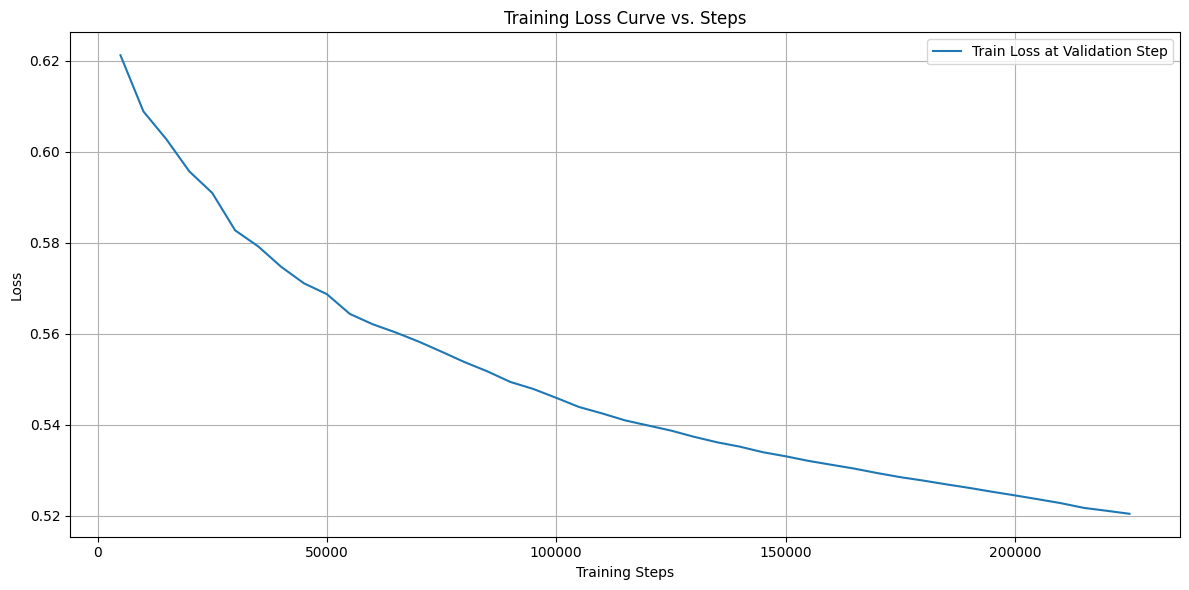

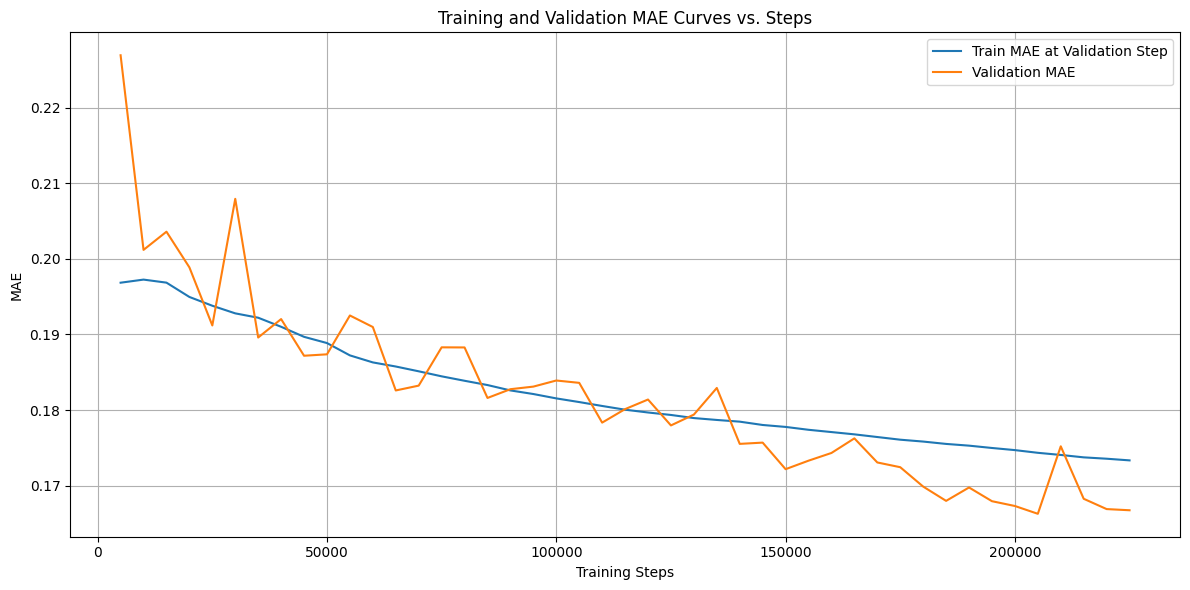

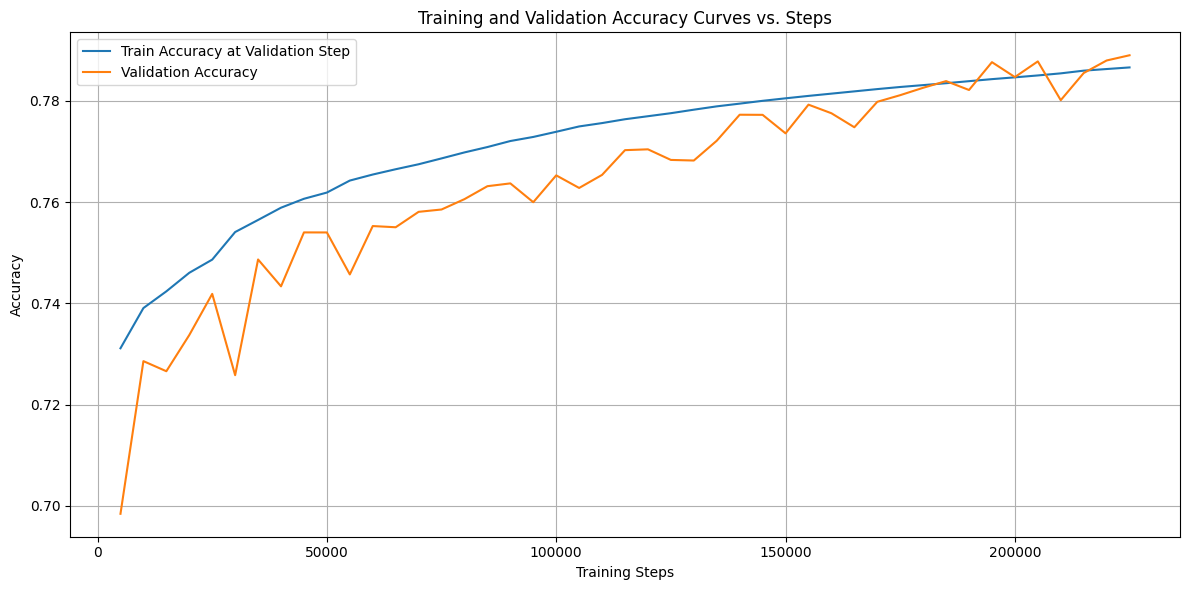

In [51]:
# --- Plotting Loss Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_losses, label='Train Loss at Validation Step')
# plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# --- Plotting MAE Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_maes, label='Train MAE at Validation Step')
plt.plot(steps, val_maes, label='Validation MAE')
plt.xlabel('Training Steps')
plt.ylabel('MAE')
plt.title('Training and Validation MAE Curves vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# --- Plotting Accuracy Curves ---
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(steps, train_win_accs, label='Train Accuracy at Validation Step')
plt.plot(steps, val_win_accs, label='Validation Accuracy')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves vs. Steps')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout

# Show all the plots
plt.show()